In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, ConcatDataset

import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import random

In [2]:
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

In [3]:
import matplotlib.pyplot as plt

# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, 'gray')
    plt.show()

In [4]:
import random

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(np.random.rand(5), torch.randn(5))

[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548 ] tensor([ 1.5410, -0.2934, -2.1788,  0.5684, -1.0845])


# Settings

In [5]:
root = os.getcwd()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

BATCH = 4

GEN_IN_CHANNELS = 1
GEN_N_CLASSES = 1

DIS_IN_CHANNELS = 1
DIS_N_CLASSES = 2

E_IN_CHANNELS = 1
E_N_CLASSES = 2

EPOCH = 200

### Model Settings

#### encoder

In [6]:
ENCODER = "resnet152"
ENCODER_WEIGHT = None

#### decoder

In [7]:
DECODER_ATT = "scse"

#### head

In [8]:
GEN_ACT = "sigmoid"
DIS_ACT = "softmax"
E_ACT = "softmax"

### Optimizer Settings

In [9]:
GEN_OPTIM_NAME = "adam"
GEN_init_lr = 1e-4
GEN_momentum = 0.9

In [10]:
DIS_OPTIM_NAME = "adam"
DIS_init_lr = 1e-3
DIS_momentum = 0.9
DIS_scheduler = "cosineAnnWarm"

In [11]:
E_OPTIM_NAME = "adam"
E_init_lr = 1e-3
E_momentum = 0.9
E_scheduler = "cosineAnnWarm"

# Epochs

In [12]:
from codes.losses import SSIMLoss
from codes.losses import MAELoss
from pytorch_msssim import ssim
from codes.metrics import PSNR, SNR, ContourEval
from codes.activation import Activation
from codes.utils import hu_clip_tensor
from codes.losses import PerceptualLoss
from kornia.filters.sobel import Sobel

In [13]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
    nets (network list)   -- a list of networks
    requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
        for net in nets:
            if net is not None:
                for param in net.parameters():
                    param.requires_grad = requires_grad

In [14]:
def replace_relu_to_leakyReLU(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, nn.LeakyReLU())
        else:
            replace_relu_to_leakyReLU(child)

In [15]:
def replace_bn_to_instanceNorm(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.BatchNorm2d):
            bn = getattr(model, child_name)
            setattr(model, child_name, nn.InstanceNorm2d(bn.num_features))
        else:
            replace_bn_to_instanceNorm(child)

In [16]:
perceptual_ext = PerceptualLoss()

In [17]:
sobel_filter = Sobel().to(device)

In [18]:
def train_d_epoch(epoch, generator, 
                    tf_discriminator, tf_d_optim, tf_scheduler, 
                    edge_discriminator, edge_d_optim, edge_scheduler, 
                    dataloader, device):

    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.train().to(device)
    edge_discriminator = edge_discriminator.train().to(device)
    
    tf_dis_l = 0
    edge_dis_l = 0

    set_requires_grad(tf_discriminator, True)
    set_requires_grad(edge_discriminator, True)
    set_requires_grad(generator, False)
    
    iteration = len(dataloader)
    
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

       ############################
        # (1) Update True/Fake D network
        ###########################
        tf_d_optim.zero_grad()

        y_cls = tf_discriminator(y)
        y_pr_cls = tf_discriminator(y_pr.detach())

        tf_dis = 0
        for _y_cls, _y_pr_cls in \
            zip(y_cls, y_pr_cls):
            B, C = _y_cls.size()
            tf_dis = nn.CrossEntropyLoss()(_y_cls.float(), torch.zeros(B, dtype=torch.long, device=device)) + \
                            nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.ones(B, dtype=torch.long, device=device)) + \
                            tf_dis

        tf_dis = tf_dis / (len(y_cls))
        tf_dis.backward()
        tf_d_optim.step()
        tf_scheduler.step(EPOCH + index / iteration)
        
        tf_dis_l += tf_dis.item()
        
       ############################
        # (2) Update Edge D network
        ###########################        
        edge_d_optim.zero_grad()        
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
 
        edge_y_cls = edge_discriminator(edge_y)
        edge_pr_cls = edge_discriminator(edge_y_pr.detach())
        
        edge_dis = 0
        for _edge_y_cls, _edge_pr_cls in \
            zip(edge_y_cls, edge_pr_cls):
            B, C = _edge_y_cls.size()
            edge_dis = nn.CrossEntropyLoss()(_edge_y_cls.float(), torch.zeros(B, dtype=torch.long, device=device)) + \
                                    nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.ones(B, dtype=torch.long, device=device)) + \
                                    edge_dis

        edge_dis = edge_dis / (len(edge_y_cls))
        edge_dis.backward()
        edge_d_optim.step()       
        edge_scheduler.step(EPOCH + index / iteration)

        edge_dis_l += edge_dis.item()


    return  edge_dis_l/(index+1), tf_dis_l/(index+1), \
                    tf_scheduler.get_last_lr()[0], edge_scheduler.get_last_lr()[0]

In [19]:
def train_g_epoch(epoch, generator, gen_optim, 
                    tf_discriminator, edge_discriminator, 
                    dataloader, device):
    
    # change mode to train and move to current device
    generator = generator.train().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    air_l = 0
    bone_l = 0
    mae_l = 0
    tf_gen_l = 0
    edge_gen_l = 0
    
    set_requires_grad(tf_discriminator, False)
    set_requires_grad(edge_discriminator, False)
    set_requires_grad(generator, True)
        
    for index, data in tqdm(enumerate(dataloader)):
        torch.cuda.empty_cache()
        
        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        ############################
        # (1) Update G network: maximize log(D(G(z)))
        ###########################
        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        assert y_pr.requires_grad, "ct_pred without gradient"
        
        gen_optim.zero_grad()

        # adversarial loss
        y_pr_cls = tf_discriminator(y_pr)
        
        tf_gen = 0
        for _y_pr_cls in y_pr_cls:
            B, C = _y_pr_cls.size()
            tf_gen = nn.CrossEntropyLoss()(_y_pr_cls.float(), torch.zeros(B, dtype=torch.long, device=device)) + \
                            tf_gen
        tf_gen = tf_gen / (len(y_pr_cls))
        

        edge_y_pr = sobel_filter(y_pr)
        edge_pr_cls = edge_discriminator(edge_y_pr)  
        
        edge_gen = 0
        for _edge_pr_cls in edge_pr_cls:
            B, C = _edge_pr_cls.size()
            edge_gen = nn.CrossEntropyLoss()(_edge_pr_cls.float(), torch.zeros(B, dtype=torch.long, device=device)) +\
                                    edge_gen
        edge_gen = edge_gen / (len(edge_pr_cls))
        
        # pixelwise loss
        _mae = MAELoss()(y_pr.float(), y.float())
        
        # auxilary loss
        # https://discuss.pytorch.org/t/unclear-about-weighted-bce-loss/21486/2
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        air_loss = nn.BCELoss()(air_pr.float(), air_x.float())
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        bone_loss = nn.BCELoss()(bone_pr.float(), bone_x.float())

        _loss = tf_gen + edge_gen + air_loss + bone_loss
        _loss.backward()    
        gen_optim.step()

        
        edge_gen_l += edge_gen.item()
        tf_gen_l += tf_gen.item()
        air_l += air_loss.item()
        bone_l += bone_loss.item()
        
    return  mae_l/(index+1), air_l/(index+1), bone_l/(index+1), \
                    edge_gen_l/(index+1), tf_gen_l/(index+1)

In [20]:
@torch.no_grad()
def eval_epoch(generator, tf_discriminator, edge_discriminator, dataloader, device):
  
    # change mode to train and move to current device
    generator = generator.eval().to(device)
    tf_discriminator = tf_discriminator.eval().to(device)
    edge_discriminator = edge_discriminator.eval().to(device)
    
    ssim_ = []
    psnr_ = []
    mae_ = []
    snr_ = []
    
    air_ = []
    bone_ = []
    cont_ = []
 
    tf_acc = []
    edge_acc = []
    
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = generator(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]

        
       ############################
        # (1) Eval True/Fake D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################        
        y_cls = tf_discriminator(y)
        for _y_cls in y_cls:
            B, C = _y_cls.size()
            total = B
            _y_cls = Activation(name=DIS_ACT)(_y_cls)
            _, _y_cls = torch.max(_y_cls.data, 1)
            correct = (_y_cls == torch.zeros(B, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]        
        
        y_pr_cls = tf_discriminator(y_pr)
        for _y_pr_cls in y_pr_cls:
            B, C = _y_pr_cls.size()
            total = B
            _y_pr_cls = Activation(name=DIS_ACT)(_y_pr_cls)
            _, _y_pr_cls = torch.max(_y_pr_cls.data, 1)
            correct = (_y_pr_cls == torch.ones(B, dtype=torch.long, device=device)).sum().item()
            tf_acc += [correct / total]

 
       ############################
        # (1.1) Eval Edge D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################  

        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        edge_y_cls = edge_discriminator(edge_y)
        for _edge_y_cls in edge_y_cls:
            B, C = _edge_y_cls.size()
            total = B
            _edge_y_cls = Activation(name=DIS_ACT)(_edge_y_cls)
            _, _edge_y_cls = torch.max(_edge_y_cls.data, 1)
            correct = (_edge_y_cls == torch.zeros((B), dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]          
        
        edge_pr_cls = edge_discriminator(edge_y_pr)
        for _edge_pr_cls in edge_pr_cls:
            B, C = _edge_pr_cls.size()
            total = B
            _edge_pr_cls = Activation(name=DIS_ACT)(_edge_pr_cls)
            _, _edge_pr_cls = torch.max(_edge_pr_cls.data, 1)
            correct = (_edge_pr_cls == torch.ones((B), dtype=torch.long, device=device)).sum().item()
            edge_acc += [correct / total]        

        ############################
        # (2) Eval G network: maximize log(D(G(z)))
        ###########################
        
        # main
        _ssim = ssim(y, y_pr, data_range=1.0, size_average=True) # return (N,)
        _psnr = PSNR()(y_pr, y, 1.0)
        _snr = SNR()(y_pr, y)
        _mae = MAELoss()(y_pr.float(), y.float())

        ssim_ += [_ssim.item()]
        psnr_ += [_psnr.item()]
        mae_ += [_mae.item()]
        snr_ += [_snr.item()]
        
        # auxilary
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(air_pr, air_x)
        air_ += [dice.item()]
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        dice = Fscore()(bone_pr, bone_x)
        bone_ += [dice.item()]

        for b in range(x.size()[0]):
            cont = ContourEval()(y_pr[b, :, :, :], x[b, :, :, :])
            cont_ += [cont.item()]

    return  sum(ssim_)/len(ssim_), sum(psnr_)/len(psnr_), sum(snr_)/len(snr_), sum(mae_)/len(mae_), \
                    sum(air_)/len(air_), sum(bone_)/len(bone_), sum(cont_)/len(cont_), sum(tf_acc)/len(tf_acc), sum(edge_acc)/len(edge_acc)

In [21]:
@torch.no_grad()
def test_epoch(model, dataloader, device, save=False, path=None):
  
    # change mode to train and move to current device
    model = model.eval().to(device)
    
    iid = 0
    for index, data in tqdm(enumerate(dataloader)):

        x, y, air_x, bone_x, *_ = data

        x = x.to(device)
        y = y.to(device)
        air_x = air_x.to(device)
        bone_x = bone_x.to(device)

        y_pr = model(x)
        y_pr = Activation(name=GEN_ACT)(y_pr) # zipped value to [0, 1]
        
        edge_x = sobel_filter(x)
        edge_y_pr = sobel_filter(y_pr)
        edge_y = sobel_filter(y)
        
        _min = -500
        _max = 500
        air_window = (-500, -499)
        upper = ((air_window[1]) - (_min))/(_max-(_min))
        lower = ((air_window[0]) - (_min))/(_max-(_min))
        air_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)
        
        bone_window = (255, 256)
        upper = ((bone_window[1]) - (_min))/(_max-(_min))
        lower = ((bone_window[0]) - (_min))/(_max-(_min))
        bone_pr = hu_clip_tensor(y_pr.double(), (lower, upper), None, True)

        for b in range(x.shape[0]):           
            tmp_y = y[b, :, :, :].unsqueeze(0)
            tmp_y_pr = y_pr[b, :, :, :].unsqueeze(0)
            tmp_air = air_x[b, :, :, :].unsqueeze(0)
            tmp_air_pr = air_pr[b, :, :, :].unsqueeze(0)
            tmp_bone = bone_x[b, :, :, :].unsqueeze(0)
            tmp_bone_pr = bone_pr[b, :, :, :].unsqueeze(0)
            
            _ssim = ssim(tmp_y, tmp_y_pr, data_range=1.0, size_average=True) # return (N,)
            _psnr = PSNR()(tmp_y_pr, tmp_y, 1.0)
            _snr = SNR()(tmp_y_pr, tmp_y)
            _mae = MAELoss()(tmp_y_pr.float(), tmp_y.float())
            _air = Fscore()(tmp_air_pr, tmp_air)
            _bone = Fscore()(tmp_bone_pr, tmp_bone)
            _cont = ContourEval()(tmp_y_pr, x[b, :, :, :])
            
            print("ssim score = {}".format(_ssim.item()))
            print("psnr score = {}".format(_psnr.item()))
            print("snr score = {}".format(_snr.item()))
            print("mae error = {}".format(_mae.item()))
            print("air dice score = {}".format(_air.item()))
            print("bone dice score = {}".format(_bone.item()))
            print("contour dice score = {}".format(_cont.item()))
            
            __cbct = (x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct = (tmp_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_pred = (tmp_y_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __ct_masked = __ct_pred * tmp_air.squeeze().cpu().numpy()
            __air = (tmp_air.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __air_pr = (tmp_air_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone = (tmp_bone.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __bone_pr = (tmp_bone_pr.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_pr = (edge_y_pr[b, :].squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_x = (edge_x.squeeze().cpu().numpy() * 255).astype(np.uint8)
            __edge_y = (edge_y.squeeze().cpu().numpy() * 255).astype(np.uint8)
            
            visualize(
                cbct = __cbct,
                ct_y = __ct,
                ct_pred = __ct_pred,
                edge_pred = __edge_pr,
                edge_x = __edge_x,
                edge_y = __edge_y,
                air = __air,
                air_pr = __air_pr,
                bone = __bone,
                bone_pr = __bone_pr
            )
            
            if save:
                path_dir = os.path.join(path, "file_{}".format(iid))
                try:
                    os.mkdir(path_dir)
                except FileExistsError:
                    pass
                
                cv2.imwrite(os.path.join(path_dir, "cbct.jpg"), __cbct)
                cv2.imwrite(os.path.join(path_dir, "ct.jpg"), __ct)
                cv2.imwrite(os.path.join(path_dir, "ct_pred.jpg"), __ct_pred)
                cv2.imwrite(os.path.join(path_dir, "air.jpg"), __air)
                cv2.imwrite(os.path.join(path_dir, "air_pred.jpg"), __air_pr)
                cv2.imwrite(os.path.join(path_dir, "bone.jpg"), __bone)
                cv2.imwrite(os.path.join(path_dir, "bone_pred.jpg"), __bone_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_pred.jpg"), __edge_pr)
                cv2.imwrite(os.path.join(path_dir, "edge_cbct.jpg"), __edge_x)
                cv2.imwrite(os.path.join(path_dir, "edge_ct.jpg"), __edge_y)
                
            iid += 1

# Discriminator

In [22]:
from codes.activation import Activation
import torchvision.models as models
from codes.losses import MultiScaleHeads

In [23]:
class Discriminator(nn.Module):
    def __init__(self, in_channel=1, n_classes=2, activation=None):
        
        super(Discriminator, self).__init__()
        
        encoder = smp.Unet(encoder_name="resnet18", in_channels=in_channel, classes=n_classes).encoder
        self.encoder = encoder
        self.fc = MultiScaleHeads(n_classes=n_classes, channels=(512, ), activation=None)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.fc([x[-1]])
        return x

# Generator

In [24]:
import segmentation_models_pytorch as smp
from codes.decoder import UnetDecoder
from segmentation_models_pytorch.base.heads import SegmentationHead

In [25]:
class Generator(nn.Module):
    def __init__(self, encoder_name, encoder_weights, in_channels, classes, attention_type):
        
        super(Generator, self).__init__()
        
        self.encoder = smp.Unet(encoder_name=encoder_name, encoder_weights=encoder_weights, in_channels=in_channels, classes=classes).encoder
        self.decoder = UnetDecoder(
                            encoder_channels=[in_channels, 0, 0, 0, 0, 2048],
                            decoder_channels=[512, 256, 128, 64, 16],
                            n_blocks=5,
                            use_batchnorm=True,
                            attention_type=attention_type)
        self.head =  SegmentationHead(
                        in_channels=16,
                        out_channels=classes,
                        activation=None)
        
        
    def forward(self, x):
        x = self.encoder(x)[-1]
        x = self.decoder(*(None, None, None, None, x))
        x = self.head(x)
        
        return x

# Read Data

In [26]:
from codes.dataset import Dataset
import codes.augmentation as aug

In [27]:
train_case_path = 'raw/train/*_*'
test_case_path = 'raw/test/*_*'

In [28]:
trainset = Dataset(train_case_path, intensity_aug=aug.training_intensity_augmentation(), geometry_aug=aug.get_training_augmentation())
testset = Dataset(test_case_path, geometry_aug=aug.get_validation_augmentation())

In [29]:
len(trainset), len(testset)

(1344, 191)

In [30]:
x, y, *_ = trainset[20]

(<matplotlib.image.AxesImage at 0x7f06dfad3430>,)

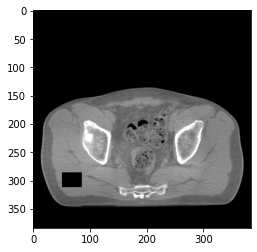

In [31]:
plt.imshow(x.squeeze(), 'gray'),

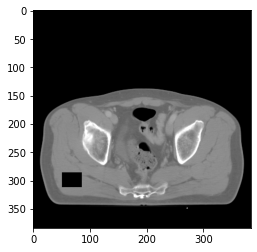

In [32]:
plt.imshow(y.squeeze(), 'gray')

In [33]:
x.shape, y.shape

((1, 384, 384), (1, 384, 384))

# training

In [34]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH, shuffle=False, num_workers=4)

In [35]:
import segmentation_models_pytorch as smp
import torchvision.models as models

model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)

replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)

In [36]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)

In [37]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)

In [38]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (relu): LeakyReLU(negative_slope=0.01)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (relu): LeakyReLU(negative_slope=0.

In [39]:
from codes.optimizer import Optimizer
# optimizer = optim.SGD(model.parameters(), lr=init_lr, momentum=momentum)
gen_optimizer = Optimizer(model.parameters(), name=GEN_OPTIM_NAME, lr=GEN_init_lr)
tf_dis_optimizer = Optimizer(tf_discriminator.parameters(), name=DIS_OPTIM_NAME, lr=DIS_init_lr)
edge_dis_optimizer = Optimizer(edge_discriminator.parameters(), name=E_OPTIM_NAME, lr=E_init_lr)

In [40]:
from codes.scheduler import Scheduler
tf_scheduler = Scheduler(tf_dis_optimizer, name=DIS_scheduler, T_0=15, T_mult=5)
edge_scheduler = Scheduler(edge_dis_optimizer, name=E_scheduler, T_0=15, T_mult=5)

In [41]:
import wandb

wandb.init(project="cbct_gan", config={
    "data": {
        "batchsize": BATCH,
    },
    "epochs": EPOCH,
    "model": {
        "in_channels": GEN_IN_CHANNELS,
        "out_channels": GEN_N_CLASSES,
        "optimizer": GEN_OPTIM_NAME,
        "init_lr": GEN_init_lr,
        "momentum": GEN_momentum,
        "encoder": ENCODER,
        "encoder_weight": ENCODER_WEIGHT,
        "activation": GEN_ACT,
        "decoder_attention_type": DECODER_ATT
    },
    "discriminator": {
        "in_channels": DIS_IN_CHANNELS,
        "out_channels": DIS_N_CLASSES,
        "optimizer": DIS_OPTIM_NAME,
        "init_lr": DIS_init_lr,
        "momentum": DIS_momentum,
        "encoder": "resnet34"
    }
})

wandb: Currently logged in as: junjun (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [42]:
wandb.watch(model)
wandb.watch(tf_discriminator)
wandb.watch(edge_discriminator)

max_score = 0

for epoch in range(EPOCH):
        
        loss_edge_dis, loss_tf_dis, tf_lr, edge_lr = train_d_epoch(epoch, model,                                                                                              
                                                                                                                       tf_discriminator, tf_dis_optimizer, tf_scheduler, 
                                                                                                                        edge_discriminator, edge_dis_optimizer, edge_scheduler,
                                                                                                                        trainloader, device)
        loss_mae, loss_air, loss_bone, loss_edge_gen, loss_tf_gen = train_g_epoch(epoch, model, gen_optimizer, 
                                                                                                                                             tf_discriminator, edge_discriminator,
                                                                                                                                             trainloader, device)
        
        score_ssim_train, score_psnr_train, score_snr_train, score_mae_train, \
            score_air_train, score_bone_train, score_cont_train, score_tf_acc_train, score_edge_acc_train = eval_epoch(model, tf_discriminator, edge_discriminator, trainloader, device)
        
        score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
            score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test = eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

        wandb.log({
            "lr scheduler tf": tf_lr,
            "lr scheduler edge": edge_lr,
            
            "loss mae": loss_mae,
            "loss mask": loss_air,
            "loss bone": loss_bone,
            "loss gen": loss_tf_gen,
            "loss dis": loss_tf_dis,
            "loss edge gen": loss_edge_gen,
            "loss edge dis": loss_edge_dis,
            
            "trainset cont score": score_cont_train,
            "trainset ssim score": score_ssim_train,
            "trainset psnr score": score_psnr_train,
            "trainset mae error": score_mae_train,
            "trainset snr score": score_snr_train,
            "trainset mask score": score_air_train,
            "trainset bone score": score_bone_train,
            "trainset acc score": score_tf_acc_train,
            "trainset edge acc score": score_edge_acc_train,
            
            "testset cont score": score_cont_test,
            "testset mae error": score_mae_test,
            "testset ssim score": score_ssim_test,
            "testset psnr score": score_psnr_test,
            "testset snr score": score_snr_test,
            "testset mask score": score_air_test,
            "testset bone score": score_bone_test,
            "testset acc score": score_tf_acc_test,
            "testset edge acc score": score_edge_acc_test
        })
        
        
        if score_air_test +  score_bone_test + score_snr_test >= max_score:
            max_score = score_air_test +  score_bone_test + score_snr_test
            checkpoint = {
                "model": model.state_dict(),
                "optimizer": gen_optimizer.state_dict(),
                "tf_discriminator": tf_discriminator.state_dict(),
                "tf_dis_optimizer": tf_dis_optimizer.state_dict(),
                "tf_scheduler": tf_scheduler.state_dict(),
                "edge_discriminator": edge_discriminator.state_dict(),
                "edge_dis_optimizer": edge_dis_optimizer.state_dict(),
                "edge_scheduler": edge_scheduler.state_dict()
            }
            torch.save(checkpoint, os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

336it [01:29,  3.76it/s]
336it [03:05,  1.81it/s]
336it [01:06,  5.05it/s]
48it [00:09,  4.89it/s]
336it [01:30,  3.73it/s]
336it [03:03,  1.84it/s]
336it [01:07,  4.96it/s]
48it [00:09,  4.96it/s]
336it [01:35,  3.53it/s]
336it [03:02,  1.84it/s]
336it [01:07,  4.94it/s]
48it [00:10,  4.68it/s]
336it [01:30,  3.70it/s]
336it [03:07,  1.79it/s]
336it [00:59,  5.63it/s]
48it [00:12,  3.88it/s]
336it [01:28,  3.79it/s]
336it [03:13,  1.74it/s]
336it [01:00,  5.59it/s]
48it [00:08,  5.51it/s]
336it [01:28,  3.80it/s]
336it [03:15,  1.72it/s]
336it [01:00,  5.60it/s]
48it [00:08,  5.45it/s]
336it [01:26,  3.87it/s]
336it [03:13,  1.73it/s]
336it [01:05,  5.14it/s]
48it [00:08,  5.53it/s]
336it [01:27,  3.84it/s]
336it [03:08,  1.78it/s]
336it [01:06,  5.07it/s]
48it [00:09,  5.02it/s]
336it [01:28,  3.81it/s]
336it [03:06,  1.80it/s]
336it [01:07,  5.01it/s]
48it [00:09,  4.91it/s]
336it [01:31,  3.66it/s]
336it [02:59,  1.87it/s]
336it [01:08,  4.92it/s]
48it [00:09,  5.16it/s]
336it [01:

In [43]:
checkpoint = torch.load(os.path.join("weight-gan", "{}.pth".format(wandb.run.name)))

In [44]:
model = smp.Unet(encoder_name=ENCODER, 
                  encoder_weights=ENCODER_WEIGHT, 
                  in_channels=GEN_IN_CHANNELS, 
                  classes=GEN_N_CLASSES,
                 decoder_attention_type=DECODER_ATT)
replace_relu_to_leakyReLU(model)
replace_bn_to_instanceNorm(model)
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [45]:
os.mkdir(os.path.join("eval-gan", wandb.run.name))

0it [00:00, ?it/s]

ssim score = 0.882046639919281
psnr score = 25.604480743408203
snr score = 15.667418479919434
mae error = 0.018416279926896095
air dice score = 0.9978756466492281
bone dice score = 0.9138658746300787
contour dice score = 0.620525062084198


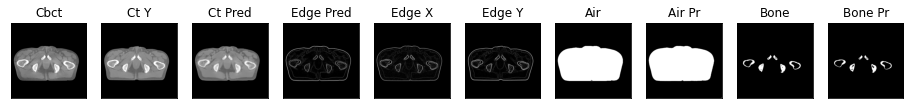

1it [00:00,  1.63it/s]

ssim score = 0.8831815719604492
psnr score = 25.50497817993164
snr score = 15.615449905395508
mae error = 0.018927915021777153
air dice score = 0.9976014941511868
bone dice score = 0.8993373303897233
contour dice score = 0.5861244201660156


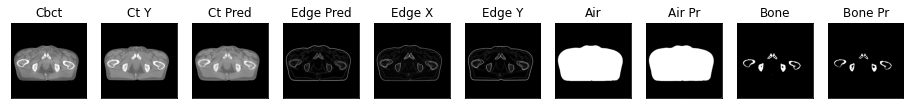

2it [00:01,  1.78it/s]

ssim score = 0.8801654577255249
psnr score = 24.936458587646484
snr score = 15.20982837677002
mae error = 0.021198472008109093
air dice score = 0.9976503897993515
bone dice score = 0.856751949653075
contour dice score = 0.5840814113616943


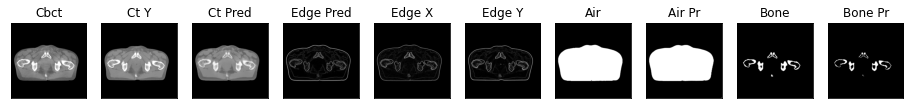

3it [00:01,  1.96it/s]

ssim score = 0.8768935203552246
psnr score = 24.77660369873047
snr score = 15.139226913452148
mae error = 0.022278865799307823
air dice score = 0.9977935382190724
bone dice score = 0.8007209062847487
contour dice score = 0.629874050617218


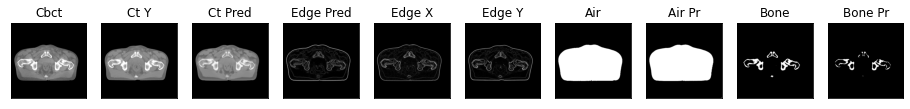

4it [00:01,  2.06it/s]

ssim score = 0.8781946301460266
psnr score = 24.77324676513672
snr score = 15.176170349121094
mae error = 0.022690853103995323
air dice score = 0.9976377096656246
bone dice score = 0.7471916898206643
contour dice score = 0.672672688961029


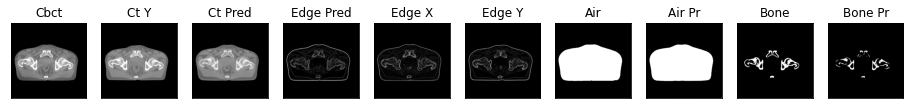

5it [00:02,  2.12it/s]

ssim score = 0.8728809952735901
psnr score = 24.324691772460938
snr score = 14.86414909362793
mae error = 0.024679161608219147
air dice score = 0.9974201742374657
bone dice score = 0.6936860068292054
contour dice score = 0.7216867208480835


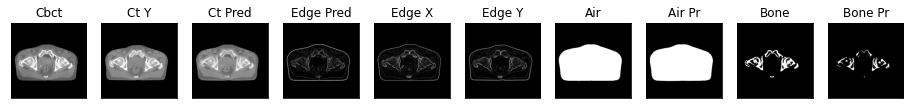

6it [00:02,  2.24it/s]

ssim score = 0.8706140518188477
psnr score = 24.285072326660156
snr score = 14.800474166870117
mae error = 0.02459852397441864
air dice score = 0.9978919604767588
bone dice score = 0.6959624796115826
contour dice score = 0.72826087474823


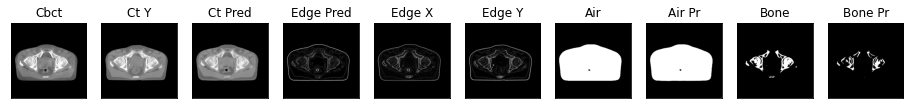

7it [00:03,  2.26it/s]

ssim score = 0.8713272213935852
psnr score = 24.954898834228516
snr score = 15.284765243530273
mae error = 0.022357549518346786
air dice score = 0.9979202041616032
bone dice score = 0.7563950350808807
contour dice score = 0.713939368724823


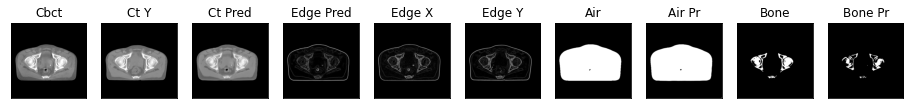

8it [00:03,  2.27it/s]

ssim score = 0.8745865225791931
psnr score = 25.474899291992188
snr score = 15.710209846496582
mae error = 0.021028276532888412
air dice score = 0.9981007798925141
bone dice score = 0.8165189092153908
contour dice score = 0.7015197277069092


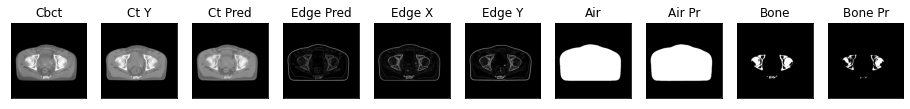

9it [00:03,  2.35it/s]

ssim score = 0.8801120519638062
psnr score = 25.512144088745117
snr score = 15.732172012329102
mae error = 0.02081153728067875
air dice score = 0.9981487509154547
bone dice score = 0.8283251805284377
contour dice score = 0.6597561240196228


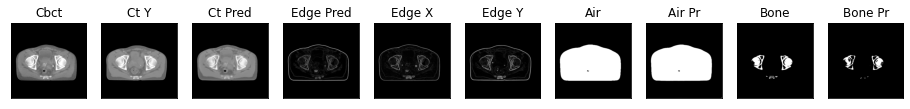

10it [00:04,  2.00it/s]

ssim score = 0.8879042863845825
psnr score = 25.66724395751953
snr score = 15.919540405273438
mae error = 0.02094023860991001
air dice score = 0.998005461965696
bone dice score = 0.8572459410720715
contour dice score = 0.6524129509925842


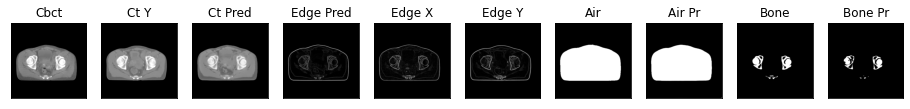

11it [00:05,  2.08it/s]

ssim score = 0.8884839415550232
psnr score = 24.82109832763672
snr score = 15.097105026245117
mae error = 0.022403093054890633
air dice score = 0.9976846109319465
bone dice score = 0.8394428152512287
contour dice score = 0.6687041521072388


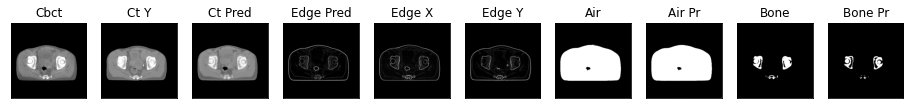

12it [00:05,  2.14it/s]

ssim score = 0.8936812281608582
psnr score = 24.318979263305664
snr score = 14.563064575195312
mae error = 0.022971684113144875
air dice score = 0.9974187210651199
bone dice score = 0.8817068551965446
contour dice score = 0.6711573600769043


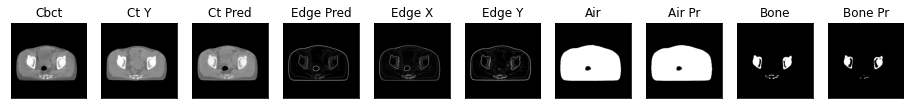

13it [00:05,  2.26it/s]

ssim score = 0.8923935294151306
psnr score = 24.456459045410156
snr score = 14.558588027954102
mae error = 0.021532142534852028
air dice score = 0.9971341270677514
bone dice score = 0.8376383763860682
contour dice score = 0.6070327162742615


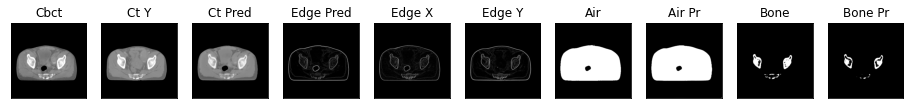

14it [00:06,  2.27it/s]

ssim score = 0.8906489014625549
psnr score = 24.52355194091797
snr score = 14.540016174316406
mae error = 0.021025296300649643
air dice score = 0.9958396409176123
bone dice score = 0.8551153163829818
contour dice score = 0.6469500660896301


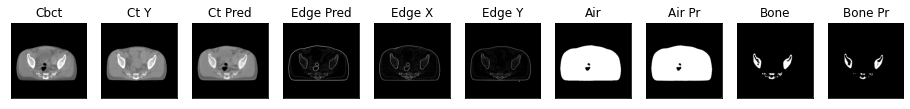

15it [00:06,  2.30it/s]

ssim score = 0.8841556310653687
psnr score = 24.121267318725586
snr score = 14.161218643188477
mae error = 0.022384127601981163
air dice score = 0.995653656042275
bone dice score = 0.8441075514896438
contour dice score = 0.7259073853492737


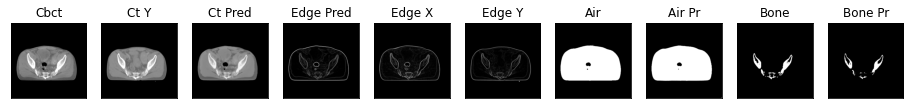

16it [00:07,  2.38it/s]

ssim score = 0.881473183631897
psnr score = 23.25141716003418
snr score = 13.288824081420898
mae error = 0.024325227364897728
air dice score = 0.9947456824152691
bone dice score = 0.8232538917230575
contour dice score = 0.697236180305481


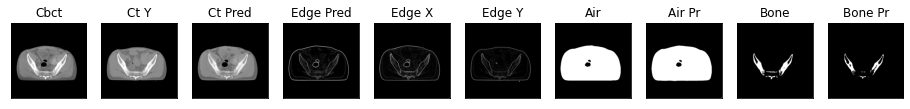

17it [00:07,  2.37it/s]

ssim score = 0.8757593035697937
psnr score = 22.833261489868164
snr score = 12.768909454345703
mae error = 0.024734800681471825
air dice score = 0.993496889816876
bone dice score = 0.7868899384601847
contour dice score = 0.6509901285171509


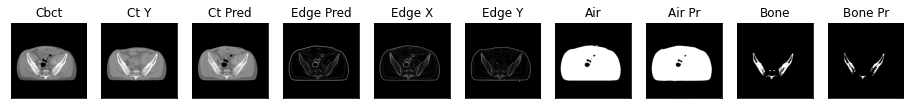

18it [00:07,  2.37it/s]

ssim score = 0.8743820786476135
psnr score = 22.65618324279785
snr score = 12.541147232055664
mae error = 0.025072481483221054
air dice score = 0.9929685446420825
bone dice score = 0.7642580089101528
contour dice score = 0.6323155164718628


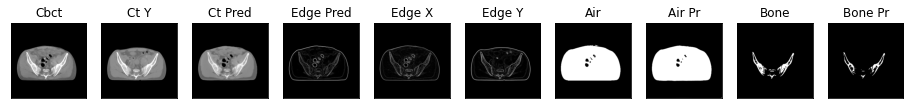

19it [00:08,  2.45it/s]

ssim score = 0.8748987317085266
psnr score = 22.618581771850586
snr score = 12.491236686706543
mae error = 0.025643235072493553
air dice score = 0.9941755283943055
bone dice score = 0.7798151679656767
contour dice score = 0.6472451090812683


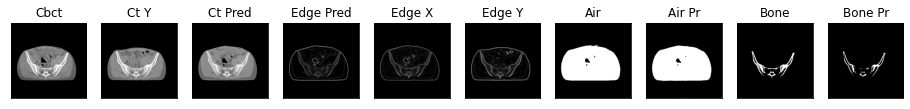

20it [00:09,  2.04it/s]

ssim score = 0.8691179156303406
psnr score = 22.473094940185547
snr score = 12.280903816223145
mae error = 0.025846699252724648
air dice score = 0.9949682734053268
bone dice score = 0.77671451356018
contour dice score = 0.6632522344589233


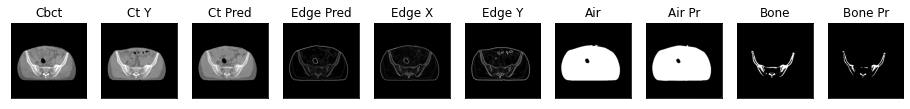

21it [00:09,  2.12it/s]

ssim score = 0.8691430687904358
psnr score = 22.604785919189453
snr score = 12.35316276550293
mae error = 0.025138601660728455
air dice score = 0.994540909549491
bone dice score = 0.7809314724826575
contour dice score = 0.5773195624351501


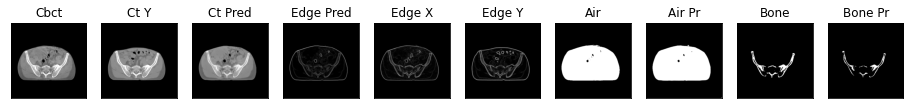

22it [00:09,  2.16it/s]

ssim score = 0.8712517619132996
psnr score = 22.667678833007812
snr score = 12.382631301879883
mae error = 0.025135787203907967
air dice score = 0.9937813622101721
bone dice score = 0.7872028177313296
contour dice score = 0.5936487317085266


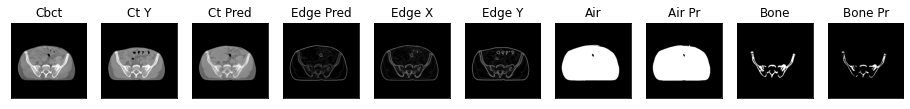

23it [00:10,  2.26it/s]

ssim score = 0.8739235997200012
psnr score = 22.647747039794922
snr score = 12.31413459777832
mae error = 0.02502746321260929
air dice score = 0.9938862033894501
bone dice score = 0.7643752702152418
contour dice score = 0.597231388092041


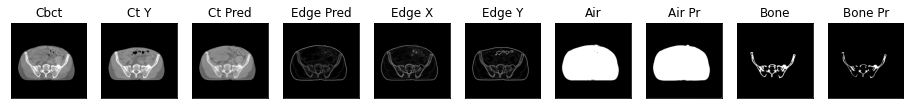

24it [00:10,  2.28it/s]

ssim score = 0.8729322552680969
psnr score = 22.529361724853516
snr score = 12.098749160766602
mae error = 0.024796659126877785
air dice score = 0.9944915401653761
bone dice score = 0.7366039869965134
contour dice score = 0.5244147181510925


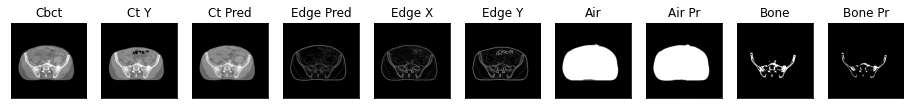

25it [00:11,  2.26it/s]

ssim score = 0.8753944039344788
psnr score = 22.610515594482422
snr score = 12.09716796875
mae error = 0.024451017379760742
air dice score = 0.9950892009869103
bone dice score = 0.7376223776260472
contour dice score = 0.6010854840278625


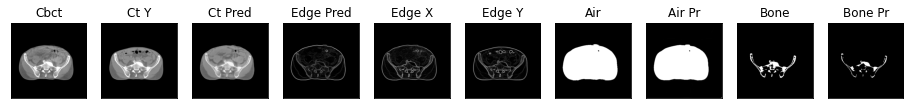

26it [00:11,  2.33it/s]

ssim score = 0.8743939399719238
psnr score = 22.741504669189453
snr score = 12.136968612670898
mae error = 0.024131707847118378
air dice score = 0.9939386606980897
bone dice score = 0.7327252625797025
contour dice score = 0.6197377443313599


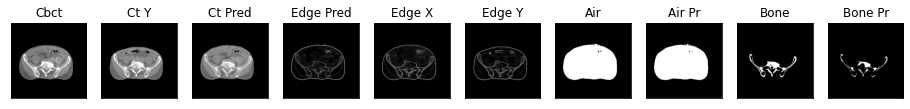

27it [00:12,  2.33it/s]

ssim score = 0.8747313022613525
psnr score = 22.597110748291016
snr score = 11.951471328735352
mae error = 0.024296458810567856
air dice score = 0.9941615150623171
bone dice score = 0.7419691825575612
contour dice score = 0.6292749643325806


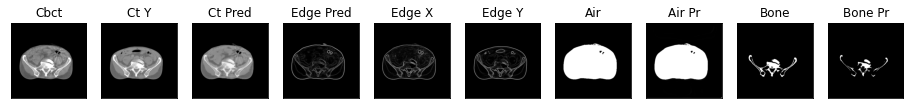

28it [00:12,  2.32it/s]

ssim score = 0.8521493673324585
psnr score = 23.959009170532227
snr score = 15.331167221069336
mae error = 0.022922536358237267
air dice score = 0.9960473328790063
bone dice score = 0.9432602821992416
contour dice score = 0.3006814420223236


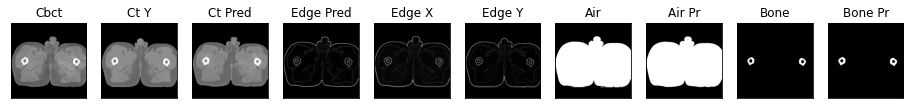

29it [00:12,  2.38it/s]

ssim score = 0.8584305047988892
psnr score = 24.63214111328125
snr score = 16.043556213378906
mae error = 0.02176493965089321
air dice score = 0.9953673876361434
bone dice score = 0.949095022625874
contour dice score = 0.26897132396698


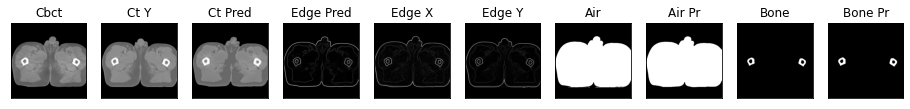

30it [00:13,  2.03it/s]

ssim score = 0.8650354743003845
psnr score = 25.239412307739258
snr score = 16.738277435302734
mae error = 0.021473892033100128
air dice score = 0.9952767230818954
bone dice score = 0.959308933849527
contour dice score = 0.25422221422195435


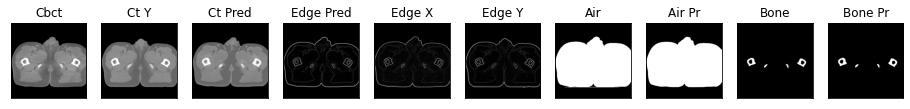

31it [00:13,  2.10it/s]

ssim score = 0.8717416524887085
psnr score = 25.55608367919922
snr score = 17.21750259399414
mae error = 0.02273918129503727
air dice score = 0.9958729523844179
bone dice score = 0.9602318467241953
contour dice score = 0.23610472679138184


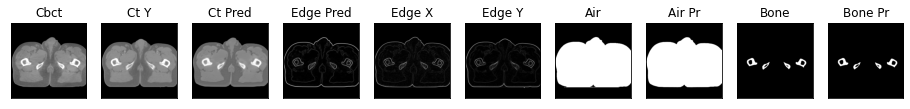

32it [00:14,  2.16it/s]

ssim score = 0.8744122982025146
psnr score = 25.62486457824707
snr score = 17.4144287109375
mae error = 0.023639271035790443
air dice score = 0.9960066114107182
bone dice score = 0.9433261955753987
contour dice score = 0.24070632457733154


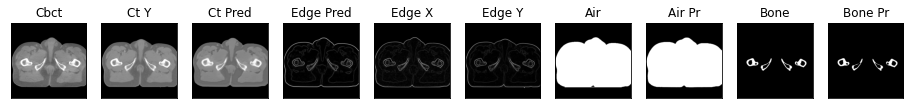

33it [00:14,  2.25it/s]

ssim score = 0.8723545074462891
psnr score = 25.83942222595215
snr score = 17.732223510742188
mae error = 0.02448432706296444
air dice score = 0.9964258038937734
bone dice score = 0.9196108550957551
contour dice score = 0.24710781872272491


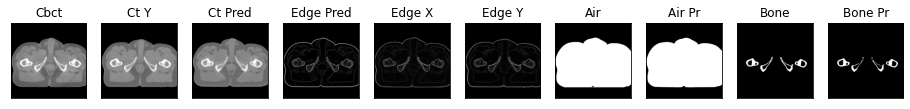

34it [00:15,  2.24it/s]

ssim score = 0.8747181296348572
psnr score = 26.100906372070312
snr score = 18.060810089111328
mae error = 0.02473321370780468
air dice score = 0.9962293963443123
bone dice score = 0.899067208802929
contour dice score = 0.21789522469043732


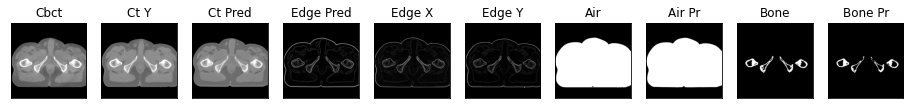

35it [00:15,  2.26it/s]

ssim score = 0.874083399772644
psnr score = 26.248132705688477
snr score = 18.198144912719727
mae error = 0.024336179718375206
air dice score = 0.9966773048587725
bone dice score = 0.9119928065649994
contour dice score = 0.2126675844192505


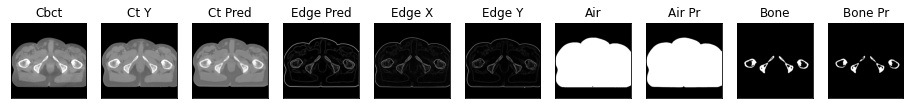

36it [00:16,  2.33it/s]

ssim score = 0.8773620128631592
psnr score = 26.47052574157715
snr score = 18.406875610351562
mae error = 0.02390262484550476
air dice score = 0.9967619818575767
bone dice score = 0.9170083102502271
contour dice score = 0.2228386551141739


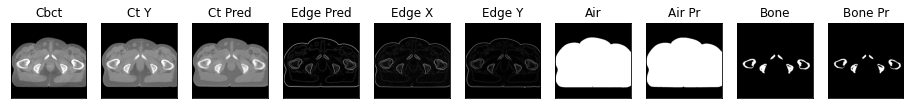

37it [00:16,  2.30it/s]

ssim score = 0.8838711380958557
psnr score = 26.785688400268555
snr score = 18.734039306640625
mae error = 0.023763060569763184
air dice score = 0.996920699084534
bone dice score = 0.9169000933716513
contour dice score = 0.21130676567554474


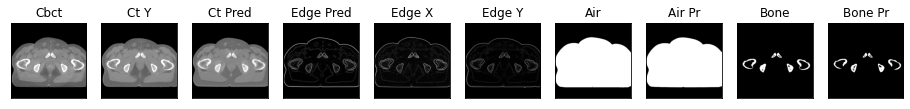

38it [00:16,  2.30it/s]

ssim score = 0.8864545226097107
psnr score = 26.693138122558594
snr score = 18.680572509765625
mae error = 0.02405478246510029
air dice score = 0.9970296441513711
bone dice score = 0.9157032755308802
contour dice score = 0.21654275059700012


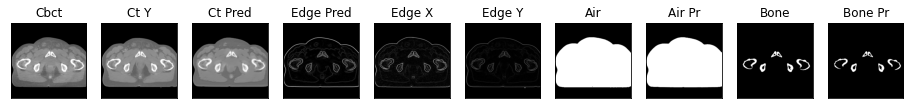

39it [00:17,  2.37it/s]

ssim score = 0.883450984954834
psnr score = 26.024473190307617
snr score = 18.1531982421875
mae error = 0.026707159355282784
air dice score = 0.9969695529199267
bone dice score = 0.8688929453466241
contour dice score = 0.22367194294929504


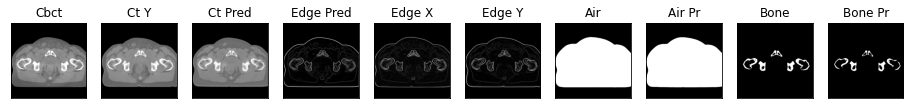

40it [00:18,  2.00it/s]

ssim score = 0.8820738196372986
psnr score = 25.472938537597656
snr score = 17.696348190307617
mae error = 0.029058940708637238
air dice score = 0.9970486730929448
bone dice score = 0.8178949322459821
contour dice score = 0.21151146292686462


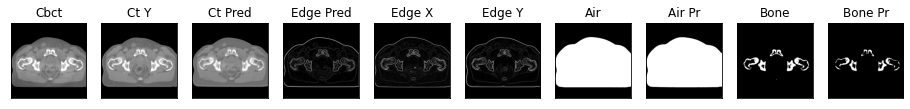

41it [00:18,  2.08it/s]

ssim score = 0.8706299662590027
psnr score = 24.82318687438965
snr score = 17.012550354003906
mae error = 0.02965688146650791
air dice score = 0.9972187074748745
bone dice score = 0.744731572425434
contour dice score = 0.22961574792861938


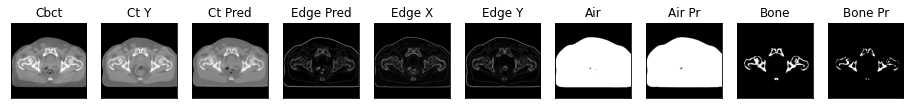

42it [00:18,  2.14it/s]

ssim score = 0.866075873374939
psnr score = 23.711111068725586
snr score = 15.972661018371582
mae error = 0.032335810363292694
air dice score = 0.9962452314439361
bone dice score = 0.6727661393785996
contour dice score = 0.25105783343315125


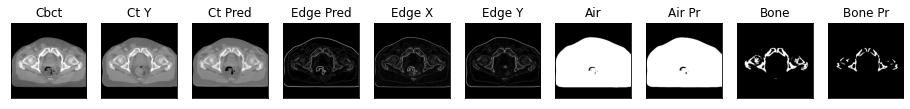

43it [00:19,  2.27it/s]

ssim score = 0.8670032620429993
psnr score = 24.176589965820312
snr score = 16.302045822143555
mae error = 0.029964787885546684
air dice score = 0.9970954756911821
bone dice score = 0.7452169367512261
contour dice score = 0.31777462363243103


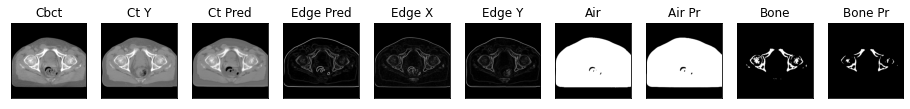

44it [00:19,  2.29it/s]

ssim score = 0.8684184551239014
psnr score = 24.89684295654297
snr score = 16.84373664855957
mae error = 0.02666272036731243
air dice score = 0.9972627241031359
bone dice score = 0.7856252125633644
contour dice score = 0.31016549468040466


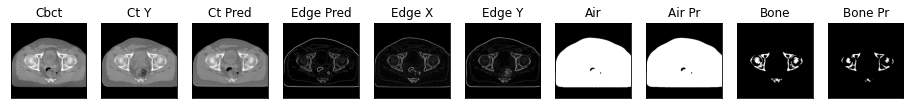

45it [00:20,  2.32it/s]

ssim score = 0.8673523664474487
psnr score = 25.235708236694336
snr score = 17.092012405395508
mae error = 0.026101453229784966
air dice score = 0.9973922881914838
bone dice score = 0.8083406168084862
contour dice score = 0.33887043595314026


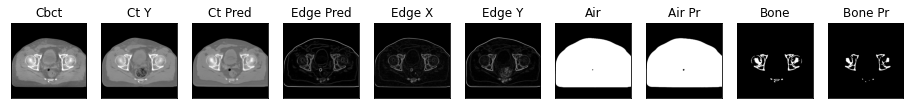

46it [00:20,  2.42it/s]

ssim score = 0.8695115447044373
psnr score = 25.26358413696289
snr score = 17.135578155517578
mae error = 0.025829417631030083
air dice score = 0.9976236636906766
bone dice score = 0.8288929719817536
contour dice score = 0.3520456850528717


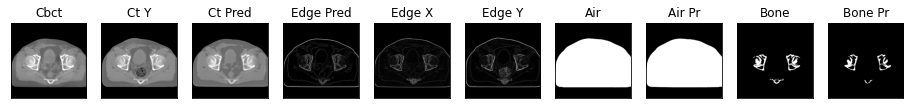

47it [00:20,  2.40it/s]

ssim score = 0.8587332367897034
psnr score = 24.965574264526367
snr score = 16.847604751586914
mae error = 0.026870625093579292
air dice score = 0.997476984354861
bone dice score = 0.8032419750474219
contour dice score = 0.33937081694602966


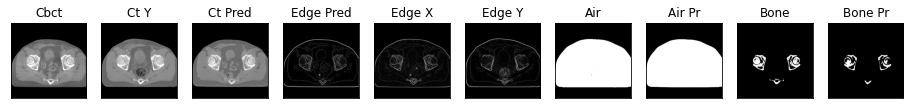

48it [00:21,  2.39it/s]

ssim score = 0.8647294044494629
psnr score = 24.99917221069336
snr score = 16.942794799804688
mae error = 0.027322927489876747
air dice score = 0.9973699537136392
bone dice score = 0.8171286719092146
contour dice score = 0.3109203577041626


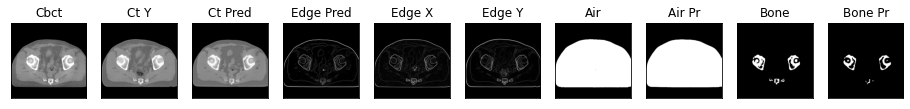

49it [00:21,  2.47it/s]

ssim score = 0.8664005994796753
psnr score = 25.213146209716797
snr score = 17.226850509643555
mae error = 0.028052644804120064
air dice score = 0.9971675913467168
bone dice score = 0.8719883889707597
contour dice score = 0.3400000035762787


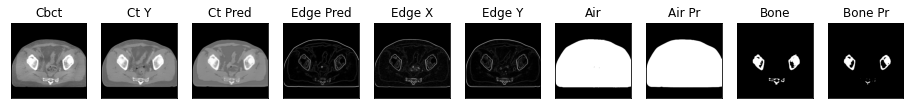

50it [00:22,  2.12it/s]

ssim score = 0.8738713264465332
psnr score = 25.508298873901367
snr score = 17.402896881103516
mae error = 0.026188796386122704
air dice score = 0.997148931463755
bone dice score = 0.8660281932651884
contour dice score = 0.3266666531562805


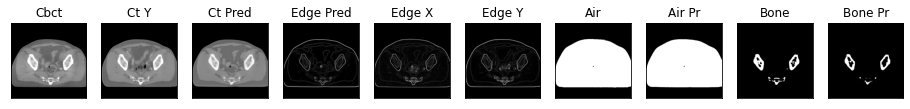

51it [00:22,  2.19it/s]

ssim score = 0.8730588555335999
psnr score = 24.694477081298828
snr score = 16.670700073242188
mae error = 0.028614316135644913
air dice score = 0.9968008743867339
bone dice score = 0.8541134147509788
contour dice score = 0.3051171600818634


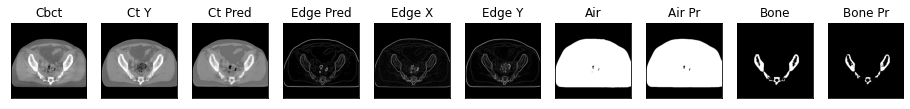

52it [00:23,  2.24it/s]

ssim score = 0.8763037919998169
psnr score = 24.602611541748047
snr score = 16.658981323242188
mae error = 0.029581235721707344
air dice score = 0.995867464560752
bone dice score = 0.8020867837048519
contour dice score = 0.2570743262767792


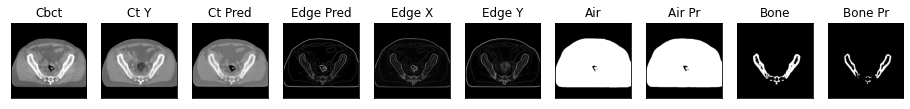

53it [00:23,  2.36it/s]

ssim score = 0.8584463596343994
psnr score = 24.11681365966797
snr score = 16.19474220275879
mae error = 0.03084178827702999
air dice score = 0.9960548769672121
bone dice score = 0.77745762712053
contour dice score = 0.2590274512767792


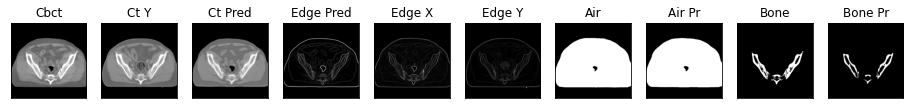

54it [00:23,  2.36it/s]

ssim score = 0.8594433665275574
psnr score = 24.753604888916016
snr score = 16.84406852722168
mae error = 0.0297530684620142
air dice score = 0.9960996026811464
bone dice score = 0.7892628887960011
contour dice score = 0.22980768978595734


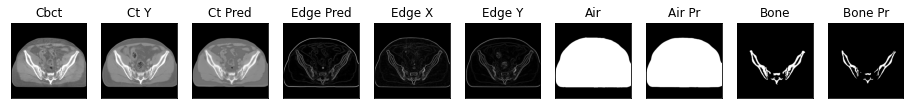

55it [00:24,  2.45it/s]

ssim score = 0.8097306489944458
psnr score = 21.17361831665039
snr score = 11.053824424743652
mae error = 0.03149527311325073
air dice score = 0.9974213696185613
bone dice score = 0.9389373513100995
contour dice score = 0.6261733770370483


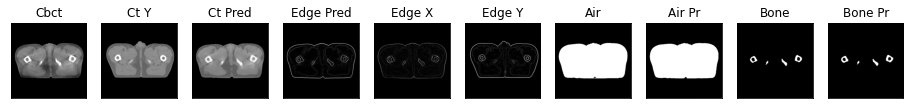

56it [00:24,  2.43it/s]

ssim score = 0.7999274730682373
psnr score = 20.89788818359375
snr score = 10.99107837677002
mae error = 0.03334824740886688
air dice score = 0.9975689392057373
bone dice score = 0.9184118673665268
contour dice score = 0.6381109356880188


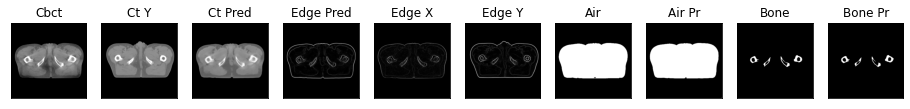

57it [00:25,  2.41it/s]

ssim score = 0.7961935997009277
psnr score = 20.919647216796875
snr score = 11.143975257873535
mae error = 0.03372553363442421
air dice score = 0.9975211933557419
bone dice score = 0.8924640135501172
contour dice score = 0.6246575117111206


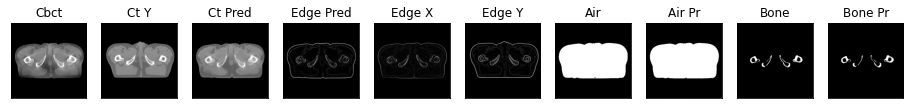

58it [00:25,  2.49it/s]

ssim score = 0.8016655445098877
psnr score = 21.25708770751953
snr score = 11.551816940307617
mae error = 0.032601192593574524
air dice score = 0.9974110770796972
bone dice score = 0.898621248988268
contour dice score = 0.6119321584701538


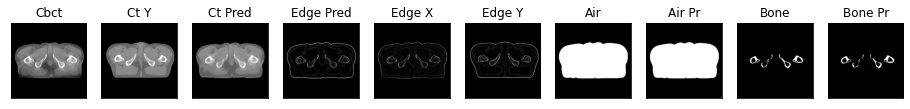

59it [00:25,  2.45it/s]

ssim score = 0.8035697340965271
psnr score = 21.36041259765625
snr score = 11.702707290649414
mae error = 0.032395537942647934
air dice score = 0.9970358582458253
bone dice score = 0.9007273442126847
contour dice score = 0.5857375860214233


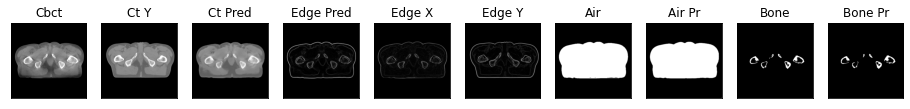

60it [00:26,  2.09it/s]

ssim score = 0.8032703399658203
psnr score = 21.505252838134766
snr score = 11.853166580200195
mae error = 0.03178435564041138
air dice score = 0.9968889160007347
bone dice score = 0.9077771439454692
contour dice score = 0.5987260937690735


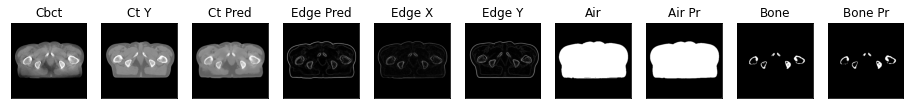

61it [00:27,  2.16it/s]

ssim score = 0.8046103715896606
psnr score = 21.580230712890625
snr score = 11.921640396118164
mae error = 0.03154633566737175
air dice score = 0.9965679928405754
bone dice score = 0.9052509203661063
contour dice score = 0.5940488576889038


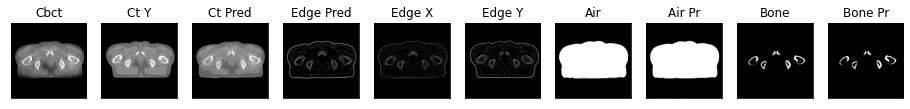

62it [00:27,  2.30it/s]

ssim score = 0.8017475605010986
psnr score = 21.428176879882812
snr score = 11.783696174621582
mae error = 0.032042235136032104
air dice score = 0.9963448646214108
bone dice score = 0.9127465857376186
contour dice score = 0.5758218169212341


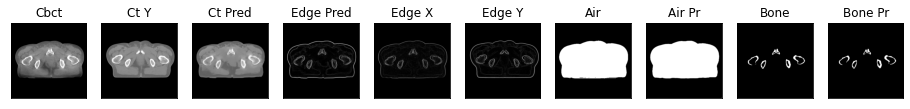

63it [00:27,  2.32it/s]

ssim score = 0.8012372851371765
psnr score = 21.274959564208984
snr score = 11.688486099243164
mae error = 0.03334849327802658
air dice score = 0.9964431290079736
bone dice score = 0.8949930458989048
contour dice score = 0.6093916893005371


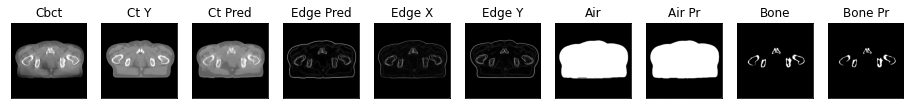

64it [00:28,  2.35it/s]

ssim score = 0.7934768199920654
psnr score = 21.10104751586914
snr score = 11.61313247680664
mae error = 0.03492409735918045
air dice score = 0.9963067789589981
bone dice score = 0.8530063021656786
contour dice score = 0.5577227473258972


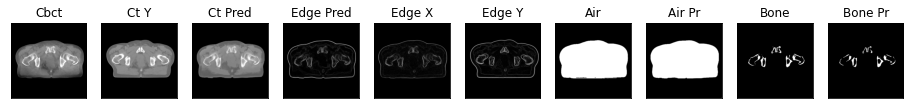

65it [00:28,  2.43it/s]

ssim score = 0.7841953039169312
psnr score = 20.970722198486328
snr score = 11.518632888793945
mae error = 0.03607489913702011
air dice score = 0.9964509070861288
bone dice score = 0.8349190452372739
contour dice score = 0.5260332822799683


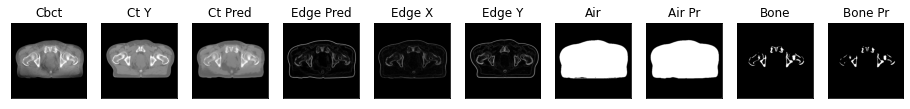

66it [00:29,  2.38it/s]

ssim score = 0.7757275104522705
psnr score = 20.8449649810791
snr score = 11.425585746765137
mae error = 0.036737021058797836
air dice score = 0.9963938687161688
bone dice score = 0.7712356727936688
contour dice score = 0.5465240478515625


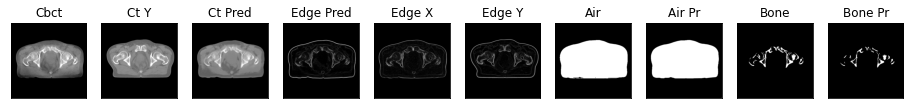

67it [00:29,  2.46it/s]

ssim score = 0.7737159729003906
psnr score = 20.807689666748047
snr score = 11.505128860473633
mae error = 0.03699776902794838
air dice score = 0.9969453694382088
bone dice score = 0.8350545883765852
contour dice score = 0.5914602279663086


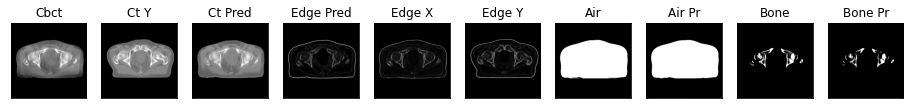

68it [00:29,  2.52it/s]

ssim score = 0.7750193476676941
psnr score = 20.845508575439453
snr score = 11.526960372924805
mae error = 0.03648074343800545
air dice score = 0.9974629112018942
bone dice score = 0.856068911513609
contour dice score = 0.5978260636329651


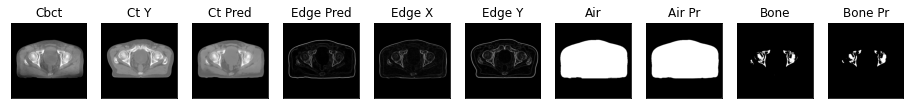

69it [00:30,  2.30it/s]

ssim score = 0.7875705361366272
psnr score = 21.450027465820312
snr score = 11.932317733764648
mae error = 0.032944872975349426
air dice score = 0.9976712010930766
bone dice score = 0.8975253807122855
contour dice score = 0.6115880012512207


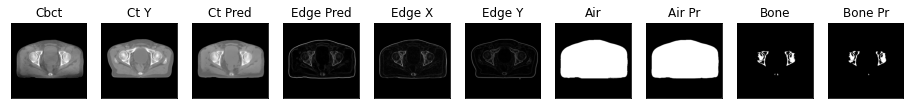

70it [00:32,  1.01s/it]

ssim score = 0.8042779564857483
psnr score = 22.1442813873291
snr score = 12.456178665161133
mae error = 0.02990906499326229
air dice score = 0.9975028104109658
bone dice score = 0.9277874061246709
contour dice score = 0.5967742204666138


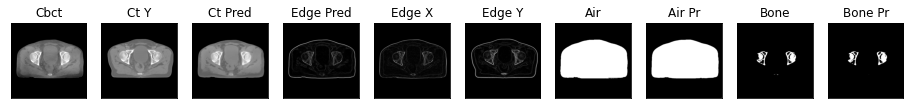

71it [00:33,  1.13it/s]

ssim score = 0.813210666179657
psnr score = 22.51496124267578
snr score = 12.841025352478027
mae error = 0.02867773547768593
air dice score = 0.9973622458592422
bone dice score = 0.9259872963280035
contour dice score = 0.6083244681358337


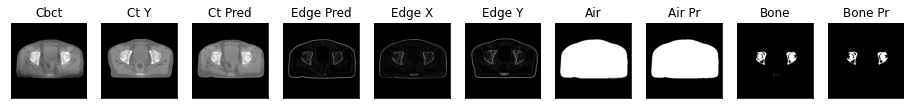

72it [00:33,  1.29it/s]

ssim score = 0.8161312341690063
psnr score = 22.67013931274414
snr score = 13.078032493591309
mae error = 0.028519928455352783
air dice score = 0.9976154457578031
bone dice score = 0.9252046288466667
contour dice score = 0.6160520315170288


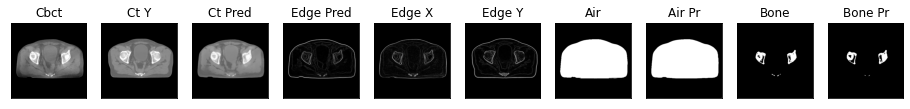

73it [00:34,  1.45it/s]

ssim score = 0.8157666921615601
psnr score = 22.63055992126465
snr score = 13.13062572479248
mae error = 0.028956225141882896
air dice score = 0.9975885545813223
bone dice score = 0.9390187987171172
contour dice score = 0.6047278642654419


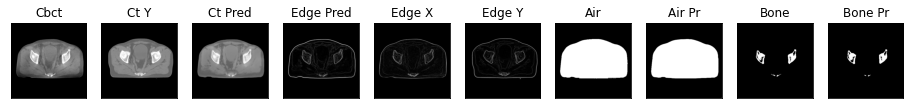

74it [00:34,  1.57it/s]

ssim score = 0.814528226852417
psnr score = 22.960773468017578
snr score = 13.397411346435547
mae error = 0.027879519388079643
air dice score = 0.9974702456748014
bone dice score = 0.9494344644053654
contour dice score = 0.6098606586456299


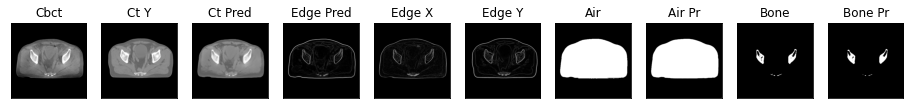

75it [00:35,  1.66it/s]

ssim score = 0.8168730139732361
psnr score = 23.133281707763672
snr score = 13.533526420593262
mae error = 0.026975439861416817
air dice score = 0.9971918453224311
bone dice score = 0.9452914798216091
contour dice score = 0.552421510219574


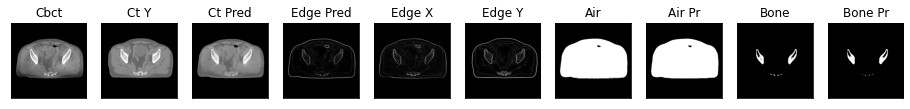

76it [00:35,  1.76it/s]

ssim score = 0.8146323561668396
psnr score = 22.790300369262695
snr score = 13.228291511535645
mae error = 0.028872454538941383
air dice score = 0.9972165175919506
bone dice score = 0.9198297872354072
contour dice score = 0.6320254802703857


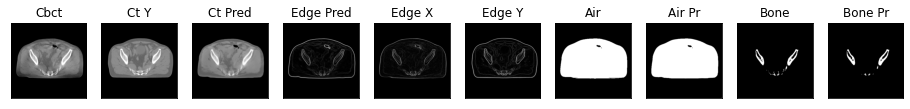

77it [00:36,  1.84it/s]

ssim score = 0.8133120536804199
psnr score = 22.646305084228516
snr score = 13.214798927307129
mae error = 0.030148668214678764
air dice score = 0.9972227648352792
bone dice score = 0.899588602774652
contour dice score = 0.6139882802963257


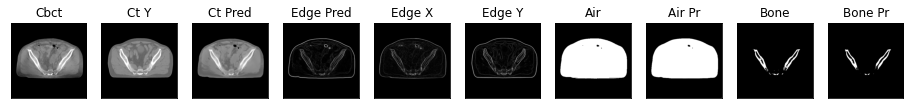

78it [00:36,  1.90it/s]

ssim score = 0.813639223575592
psnr score = 22.503374099731445
snr score = 13.089618682861328
mae error = 0.030527228489518166
air dice score = 0.9969992498124557
bone dice score = 0.8569507480272828
contour dice score = 0.5818572044372559


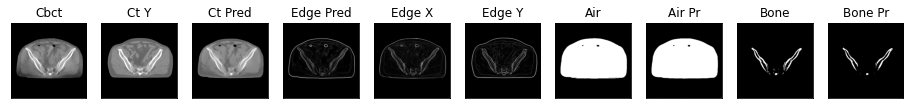

79it [00:37,  1.99it/s]

ssim score = 0.817393958568573
psnr score = 22.892250061035156
snr score = 13.467225074768066
mae error = 0.02936968207359314
air dice score = 0.9970889414021054
bone dice score = 0.8676900584819501
contour dice score = 0.600862979888916


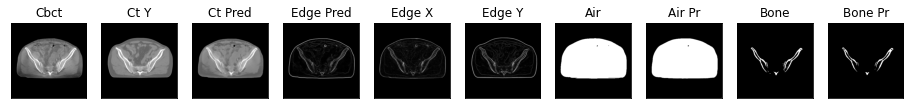

80it [00:38,  1.70it/s]

ssim score = 0.8189414739608765
psnr score = 22.9448299407959
snr score = 13.519063949584961
mae error = 0.029031697660684586
air dice score = 0.9967517959646678
bone dice score = 0.8462791960918653
contour dice score = 0.5900925397872925


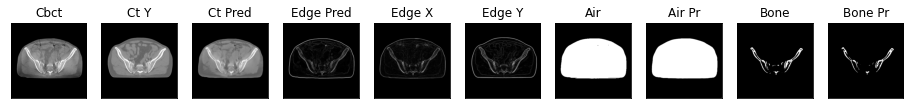

81it [00:38,  1.80it/s]

ssim score = 0.8681495189666748
psnr score = 23.783552169799805
snr score = 14.21768569946289
mae error = 0.020448826253414154
air dice score = 0.9968793287372452
bone dice score = 0.8767869298884687
contour dice score = 0.5


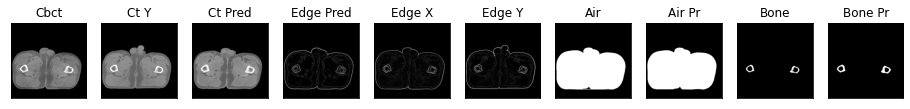

82it [00:39,  1.86it/s]

ssim score = 0.8691406846046448
psnr score = 24.040353775024414
snr score = 14.538880348205566
mae error = 0.0202464759349823
air dice score = 0.9964793468199431
bone dice score = 0.8719701678100693
contour dice score = 0.45507094264030457


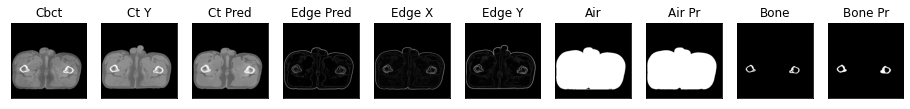

83it [00:39,  1.94it/s]

ssim score = 0.8764324188232422
psnr score = 25.44156265258789
snr score = 16.079299926757812
mae error = 0.019403286278247833
air dice score = 0.9971931854608592
bone dice score = 0.9211653813213118
contour dice score = 0.4796747863292694


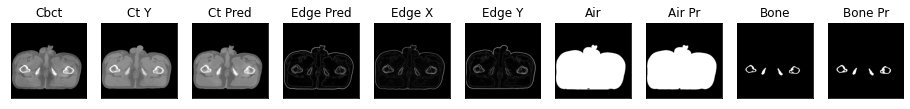

84it [00:39,  1.97it/s]

ssim score = 0.8750948309898376
psnr score = 25.441017150878906
snr score = 16.20024871826172
mae error = 0.020252922549843788
air dice score = 0.9978216558527456
bone dice score = 0.8981788079491271
contour dice score = 0.5316195487976074


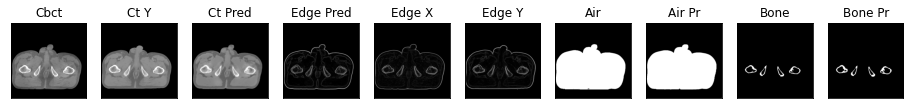

85it [00:40,  2.00it/s]

ssim score = 0.8715806603431702
psnr score = 25.2602596282959
snr score = 16.043663024902344
mae error = 0.020520176738500595
air dice score = 0.9980677453148659
bone dice score = 0.8806818181844257
contour dice score = 0.5440414547920227


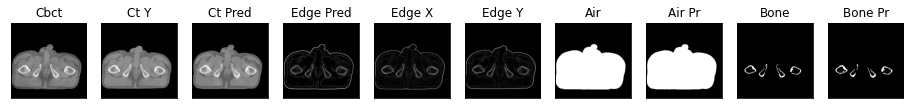

86it [00:40,  2.06it/s]

ssim score = 0.8695986866950989
psnr score = 25.09395980834961
snr score = 15.872965812683105
mae error = 0.020905183628201485
air dice score = 0.9978448275862085
bone dice score = 0.8850806451636073
contour dice score = 0.540062427520752


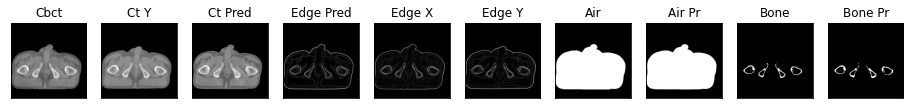

87it [00:41,  2.05it/s]

ssim score = 0.8702191114425659
psnr score = 24.7000675201416
snr score = 15.485328674316406
mae error = 0.02153019607067108
air dice score = 0.9975592558442282
bone dice score = 0.8948095520052337
contour dice score = 0.5115545988082886


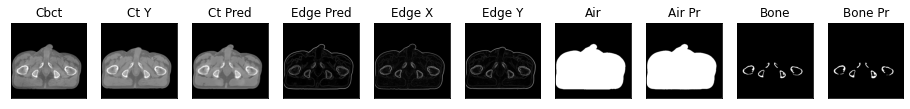

88it [00:41,  2.06it/s]

ssim score = 0.868249237537384
psnr score = 24.421741485595703
snr score = 15.185447692871094
mae error = 0.021656842902302742
air dice score = 0.9980919583023098
bone dice score = 0.898087916422273
contour dice score = 0.5481325387954712


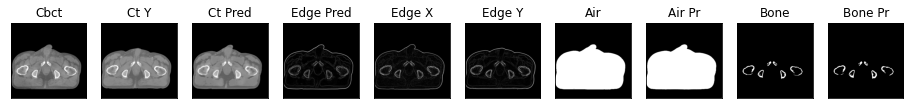

89it [00:42,  2.09it/s]

ssim score = 0.8695796728134155
psnr score = 24.40458106994629
snr score = 15.185197830200195
mae error = 0.021595444530248642
air dice score = 0.9975489242500895
bone dice score = 0.9139947189755943
contour dice score = 0.5092641711235046


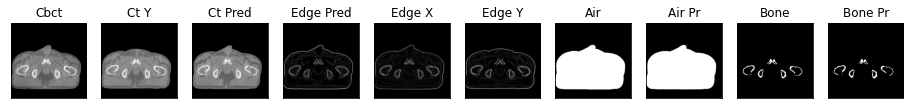

90it [00:43,  1.74it/s]

ssim score = 0.871856153011322
psnr score = 24.654932022094727
snr score = 15.504140853881836
mae error = 0.02165899984538555
air dice score = 0.9979386273131897
bone dice score = 0.9035302341855378
contour dice score = 0.5514666438102722


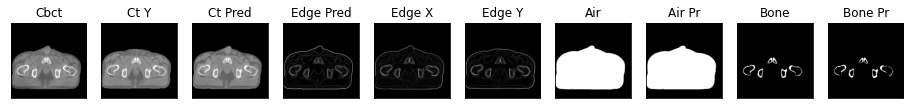

91it [00:43,  1.79it/s]

ssim score = 0.8709149956703186
psnr score = 24.939786911010742
snr score = 15.870353698730469
mae error = 0.02224862575531006
air dice score = 0.9979535671441693
bone dice score = 0.8793787177812397
contour dice score = 0.5921547412872314


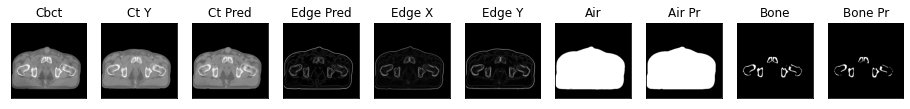

92it [00:44,  1.86it/s]

ssim score = 0.8712374567985535
psnr score = 25.198646545410156
snr score = 16.179916381835938
mae error = 0.022509129717946053
air dice score = 0.9984494171540127
bone dice score = 0.8395102040842529
contour dice score = 0.6960257887840271


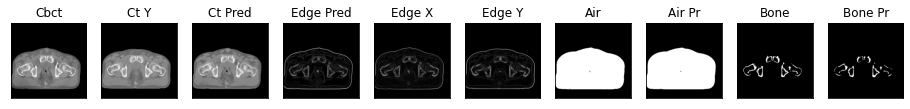

93it [00:44,  1.89it/s]

ssim score = 0.8735681176185608
psnr score = 25.276554107666016
snr score = 16.374094009399414
mae error = 0.02346291020512581
air dice score = 0.9985554266227781
bone dice score = 0.7703632581249742
contour dice score = 0.6562835574150085


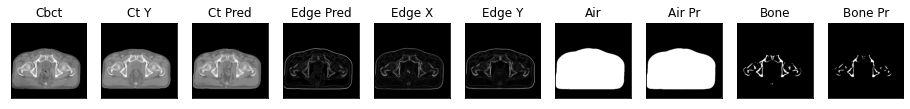

94it [00:45,  1.94it/s]

ssim score = 0.8737712502479553
psnr score = 24.97575569152832
snr score = 16.035058975219727
mae error = 0.023155152797698975
air dice score = 0.9988495259253392
bone dice score = 0.7789904502084074
contour dice score = 0.6846070885658264


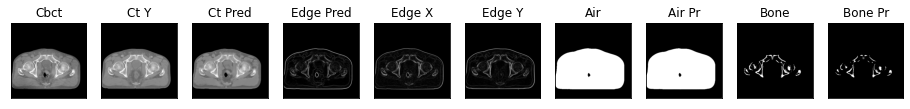

95it [00:45,  1.96it/s]

ssim score = 0.8690239787101746
psnr score = 24.410287857055664
snr score = 15.373920440673828
mae error = 0.02322983741760254
air dice score = 0.9982413787590543
bone dice score = 0.8093769278252718
contour dice score = 0.5815832018852234


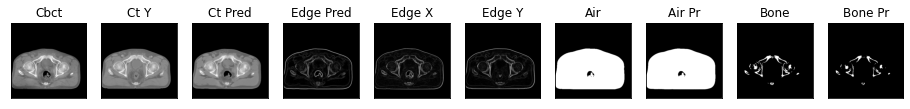

96it [00:46,  2.00it/s]

ssim score = 0.874467134475708
psnr score = 24.406482696533203
snr score = 15.210356712341309
mae error = 0.02178318239748478
air dice score = 0.9981001754922654
bone dice score = 0.8737931034504518
contour dice score = 0.6435911059379578


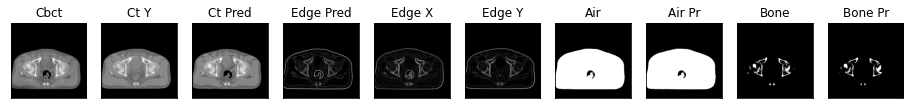

97it [00:46,  2.04it/s]

ssim score = 0.8718417286872864
psnr score = 24.04930305480957
snr score = 14.736753463745117
mae error = 0.021879548206925392
air dice score = 0.997566276239858
bone dice score = 0.8654583478587407
contour dice score = 0.5982627868652344


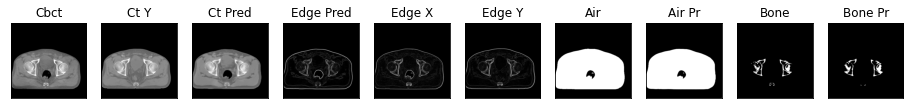

98it [00:47,  2.07it/s]

ssim score = 0.8700022101402283
psnr score = 23.987228393554688
snr score = 14.629583358764648
mae error = 0.022153280675411224
air dice score = 0.9977717337877267
bone dice score = 0.883767202787535
contour dice score = 0.6281981468200684


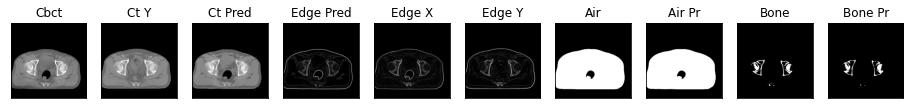

99it [00:47,  2.04it/s]

ssim score = 0.8628451228141785
psnr score = 23.440654754638672
snr score = 14.089683532714844
mae error = 0.023954911157488823
air dice score = 0.9980063501439874
bone dice score = 0.8907619689836351
contour dice score = 0.6022913455963135


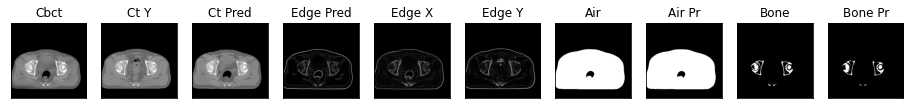

100it [00:48,  1.75it/s]

ssim score = 0.8637852668762207
psnr score = 23.11342430114746
snr score = 13.792556762695312
mae error = 0.024943964555859566
air dice score = 0.9982085332982724
bone dice score = 0.9127879269275173
contour dice score = 0.6178239583969116


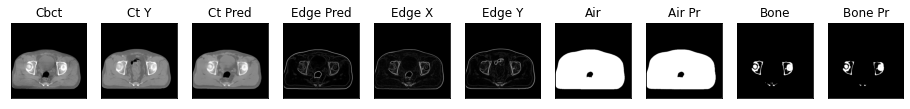

101it [00:48,  1.84it/s]

ssim score = 0.8706690073013306
psnr score = 23.833572387695312
snr score = 14.470118522644043
mae error = 0.022982414811849594
air dice score = 0.9979733000746696
bone dice score = 0.9167827298064627
contour dice score = 0.5520262718200684


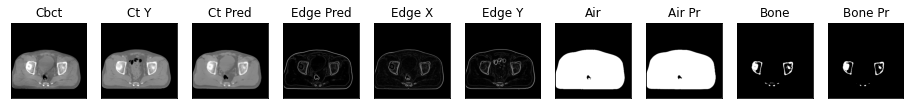

102it [00:49,  1.89it/s]

ssim score = 0.870585024356842
psnr score = 24.114789962768555
snr score = 14.661130905151367
mae error = 0.021462179720401764
air dice score = 0.9980880171419169
bone dice score = 0.9086792452847419
contour dice score = 0.5229759216308594


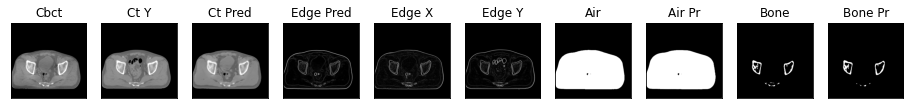

103it [00:49,  1.92it/s]

ssim score = 0.8694082498550415
psnr score = 23.76671028137207
snr score = 14.247326850891113
mae error = 0.022041475400328636
air dice score = 0.9982098102398869
bone dice score = 0.9218595450064914
contour dice score = 0.5587266683578491


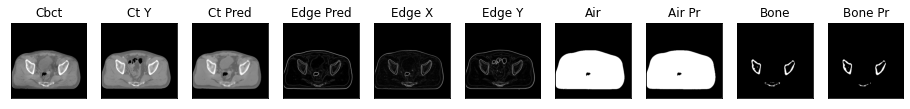

104it [00:50,  2.01it/s]

ssim score = 0.8683003187179565
psnr score = 23.96070098876953
snr score = 14.441012382507324
mae error = 0.021837348118424416
air dice score = 0.9977013808493166
bone dice score = 0.9143060751841385
contour dice score = 0.5780220031738281


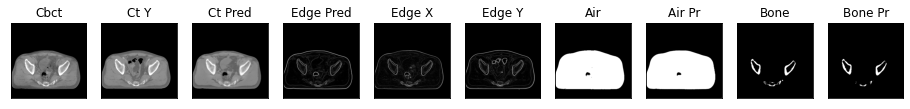

105it [00:50,  2.03it/s]

ssim score = 0.86269211769104
psnr score = 23.810710906982422
snr score = 14.36719036102295
mae error = 0.02360815741121769
air dice score = 0.9973574997882635
bone dice score = 0.8808464959380333
contour dice score = 0.6412803530693054


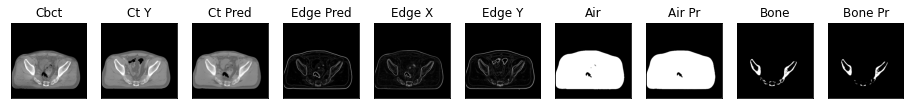

106it [00:51,  2.02it/s]

ssim score = 0.8655562400817871
psnr score = 23.979042053222656
snr score = 14.5711030960083
mae error = 0.023549525067210197
air dice score = 0.9976556039590475
bone dice score = 0.8603123631607019
contour dice score = 0.6173384785652161


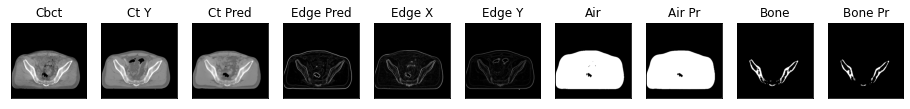

107it [00:51,  2.07it/s]

ssim score = 0.8672311305999756
psnr score = 24.741458892822266
snr score = 15.271821975708008
mae error = 0.021872762590646744
air dice score = 0.9975658255622621
bone dice score = 0.8521388716699917
contour dice score = 0.6021029353141785


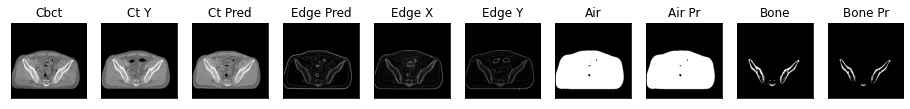

108it [00:52,  2.07it/s]

ssim score = 0.8651797771453857
psnr score = 24.51648712158203
snr score = 14.985589027404785
mae error = 0.02205798402428627
air dice score = 0.997494643721061
bone dice score = 0.8408378690443536
contour dice score = 0.6129754185676575


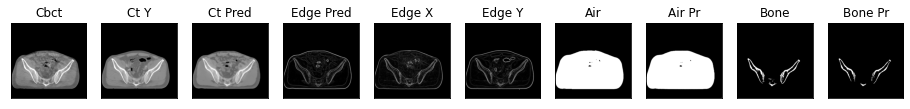

109it [00:52,  2.04it/s]

ssim score = 0.7935393452644348
psnr score = 22.253276824951172
snr score = 13.950584411621094
mae error = 0.031870704144239426
air dice score = 0.9968640144172362
bone dice score = 0.9320732427663297
contour dice score = 0.3034847676753998


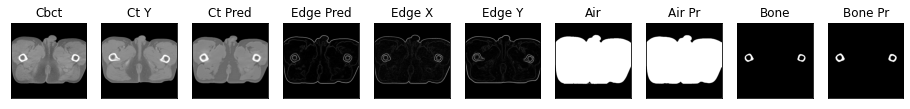

110it [00:53,  1.72it/s]

ssim score = 0.7851883172988892
psnr score = 21.922821044921875
snr score = 13.724420547485352
mae error = 0.03402552381157875
air dice score = 0.9969880760820251
bone dice score = 0.9256721138659548
contour dice score = 0.29016464948654175


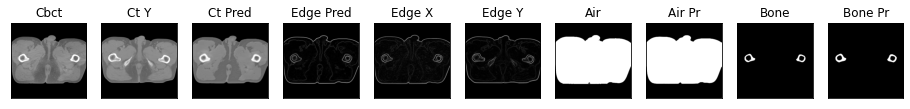

111it [00:53,  1.80it/s]

ssim score = 0.777820348739624
psnr score = 21.579669952392578
snr score = 13.509225845336914
mae error = 0.03717881068587303
air dice score = 0.996691718719703
bone dice score = 0.9054768450009415
contour dice score = 0.28277406096458435


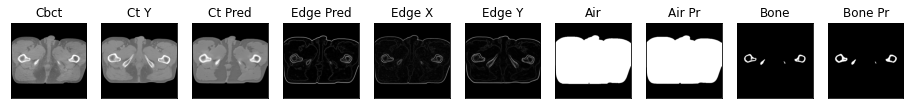

112it [00:54,  1.86it/s]

ssim score = 0.7707399129867554
psnr score = 21.280546188354492
snr score = 13.242389678955078
mae error = 0.03855116665363312
air dice score = 0.9964544202537601
bone dice score = 0.9231020942420959
contour dice score = 0.2699551582336426


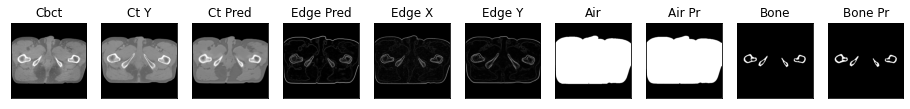

113it [00:54,  1.95it/s]

ssim score = 0.7625347971916199
psnr score = 21.234397888183594
snr score = 13.226476669311523
mae error = 0.0390794463455677
air dice score = 0.9965050495605032
bone dice score = 0.8901026150299552
contour dice score = 0.2828828692436218


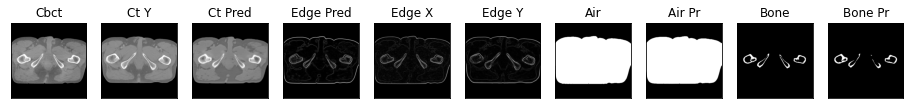

114it [00:55,  1.98it/s]

ssim score = 0.7581583857536316
psnr score = 21.110055923461914
snr score = 13.136554718017578
mae error = 0.04018618166446686
air dice score = 0.9965566864953381
bone dice score = 0.8969171483638902
contour dice score = 0.2725631892681122


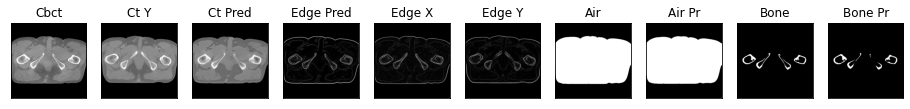

115it [00:55,  2.00it/s]

ssim score = 0.7490537762641907
psnr score = 20.864809036254883
snr score = 12.911619186401367
mae error = 0.041652314364910126
air dice score = 0.9963598362797199
bone dice score = 0.8921484037979271
contour dice score = 0.2873874008655548


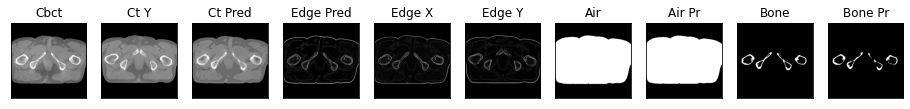

116it [00:56,  2.00it/s]

ssim score = 0.7504962682723999
psnr score = 20.932004928588867
snr score = 13.017887115478516
mae error = 0.04133158177137375
air dice score = 0.9960473391985742
bone dice score = 0.884426466340878
contour dice score = 0.31616657972335815


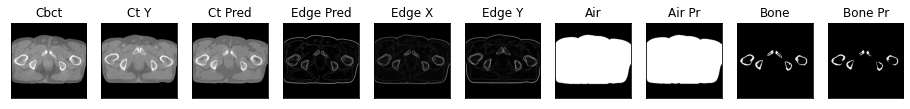

117it [00:56,  2.04it/s]

ssim score = 0.7506400942802429
psnr score = 20.989925384521484
snr score = 13.124486923217773
mae error = 0.0418691523373127
air dice score = 0.9953159420289882
bone dice score = 0.8910391249489407
contour dice score = 0.3081597089767456


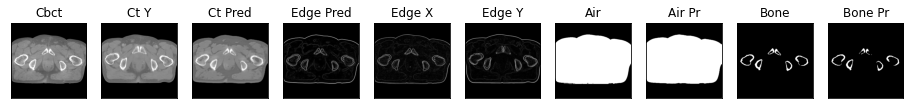

118it [00:57,  2.09it/s]

ssim score = 0.7395280003547668
psnr score = 20.75923728942871
snr score = 12.916407585144043
mae error = 0.043815743178129196
air dice score = 0.995620590177612
bone dice score = 0.8805908904406977
contour dice score = 0.30161428451538086


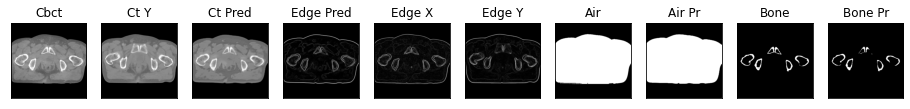

119it [00:57,  2.07it/s]

ssim score = 0.7274342179298401
psnr score = 20.705524444580078
snr score = 12.905475616455078
mae error = 0.045099496841430664
air dice score = 0.996046151356103
bone dice score = 0.8502946954832967
contour dice score = 0.2813429534435272


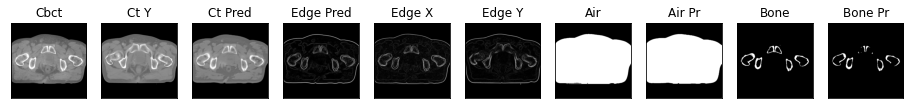

120it [00:58,  1.74it/s]

ssim score = 0.7299852967262268
psnr score = 20.564525604248047
snr score = 12.822813987731934
mae error = 0.04602231830358505
air dice score = 0.9959668126296405
bone dice score = 0.8376172493624361
contour dice score = 0.2805265486240387


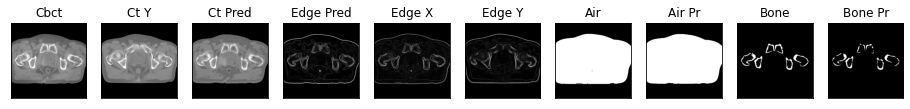

121it [00:59,  1.83it/s]

ssim score = 0.7261744737625122
psnr score = 20.54943084716797
snr score = 12.732349395751953
mae error = 0.046627290546894073
air dice score = 0.9960205251063999
bone dice score = 0.7822776047100233
contour dice score = 0.27438467741012573


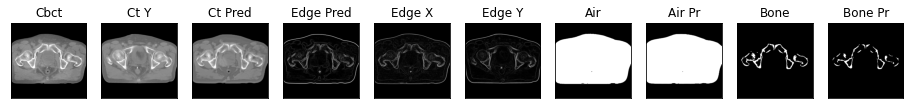

122it [00:59,  1.87it/s]

ssim score = 0.732790470123291
psnr score = 20.564611434936523
snr score = 12.640310287475586
mae error = 0.046181220561265945
air dice score = 0.9960211208807683
bone dice score = 0.7585416188975173
contour dice score = 0.26898443698883057


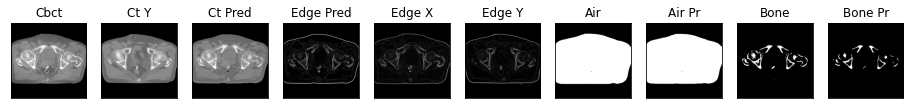

123it [01:00,  1.91it/s]

ssim score = 0.7471892833709717
psnr score = 21.035987854003906
snr score = 12.988600730895996
mae error = 0.04289108142256737
air dice score = 0.9960683031442068
bone dice score = 0.721090019800616
contour dice score = 0.26697248220443726


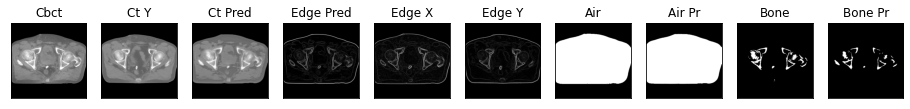

124it [01:00,  1.93it/s]

ssim score = 0.7478595972061157
psnr score = 21.301342010498047
snr score = 13.141519546508789
mae error = 0.0408681221306324
air dice score = 0.9965391926323534
bone dice score = 0.8181504882272469
contour dice score = 0.27874884009361267


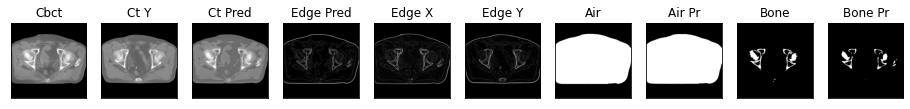

125it [01:01,  1.97it/s]

ssim score = 0.7455994486808777
psnr score = 21.52539825439453
snr score = 13.314932823181152
mae error = 0.038532741367816925
air dice score = 0.9965705414141902
bone dice score = 0.8703067892361246
contour dice score = 0.26284128427505493


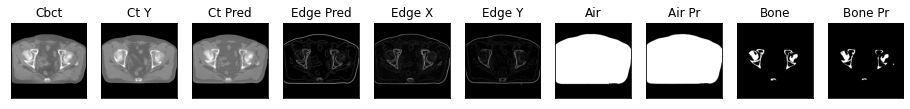

126it [01:01,  1.99it/s]

ssim score = 0.7441136837005615
psnr score = 21.293136596679688
snr score = 13.114825248718262
mae error = 0.04004340618848801
air dice score = 0.9965872688267085
bone dice score = 0.8746641747474049
contour dice score = 0.25185874104499817


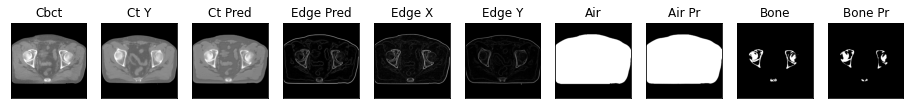

127it [01:02,  2.01it/s]

ssim score = 0.7449100613594055
psnr score = 21.05727195739746
snr score = 12.892437934875488
mae error = 0.04090069606900215
air dice score = 0.9968550339878071
bone dice score = 0.8927188709892254
contour dice score = 0.2289719581604004


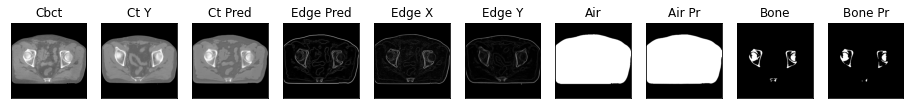

128it [01:02,  2.04it/s]

ssim score = 0.7432391047477722
psnr score = 20.654380798339844
snr score = 12.34805679321289
mae error = 0.04276999458670616
air dice score = 0.9966571659805079
bone dice score = 0.8937756243024751
contour dice score = 0.20735155045986176


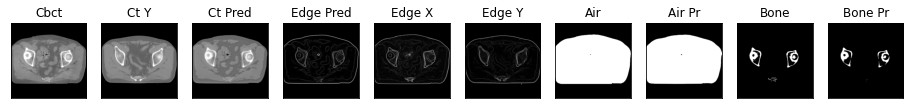

129it [01:03,  2.04it/s]

ssim score = 0.7535430788993835
psnr score = 20.792007446289062
snr score = 12.426374435424805
mae error = 0.04137195274233818
air dice score = 0.9967756576892036
bone dice score = 0.896947111940706
contour dice score = 0.21087470650672913


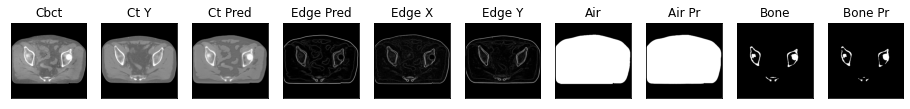

130it [01:03,  1.85it/s]

ssim score = 0.7477397918701172
psnr score = 21.04334831237793
snr score = 12.703362464904785
mae error = 0.03998689725995064
air dice score = 0.9970805772521913
bone dice score = 0.8934811196713605
contour dice score = 0.23462630808353424


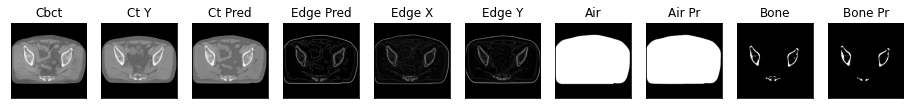

131it [01:04,  2.01it/s]

ssim score = 0.7410388588905334
psnr score = 20.825031280517578
snr score = 12.55785846710205
mae error = 0.04113893583416939
air dice score = 0.9967913801827564
bone dice score = 0.8981530343025831
contour dice score = 0.2130681872367859


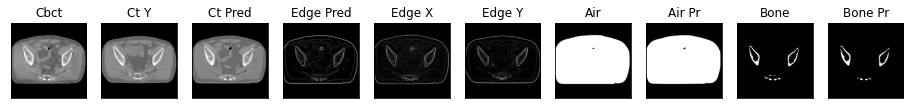

132it [01:04,  2.14it/s]

ssim score = 0.7325774431228638
psnr score = 20.39422035217285
snr score = 12.256278038024902
mae error = 0.043722111731767654
air dice score = 0.997150076037889
bone dice score = 0.9083374772102049
contour dice score = 0.22391614317893982


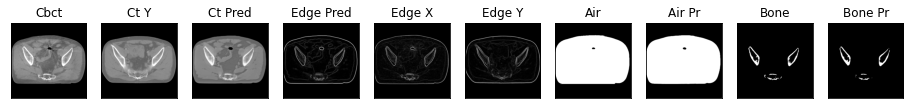

133it [01:04,  2.23it/s]

ssim score = 0.7275357842445374
psnr score = 20.2342529296875
snr score = 12.130270957946777
mae error = 0.044712092727422714
air dice score = 0.996879969161087
bone dice score = 0.8933125972022813
contour dice score = 0.22062350809574127


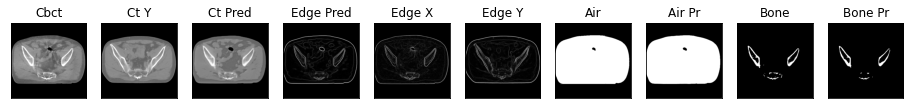

134it [01:05,  2.32it/s]

ssim score = 0.7187184691429138
psnr score = 20.31806182861328
snr score = 12.184289932250977
mae error = 0.045140404254198074
air dice score = 0.9966593167608079
bone dice score = 0.8595238095256676
contour dice score = 0.19528619945049286


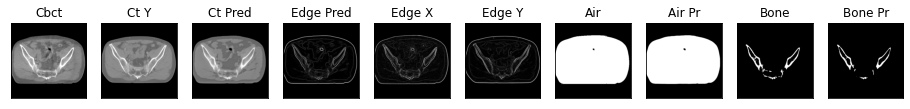

135it [01:05,  2.35it/s]

ssim score = 0.7174369692802429
psnr score = 20.67569351196289
snr score = 12.478544235229492
mae error = 0.0433088019490242
air dice score = 0.9968970825303342
bone dice score = 0.8405964963104011
contour dice score = 0.20386473834514618


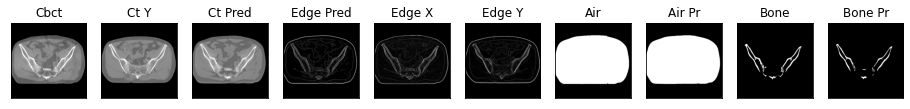

136it [01:06,  2.40it/s]

ssim score = 0.8278696537017822
psnr score = 22.631336212158203
snr score = 14.108725547790527
mae error = 0.03259902447462082
air dice score = 0.9983090067639742
bone dice score = 0.8261992118517978
contour dice score = 0.4962330460548401


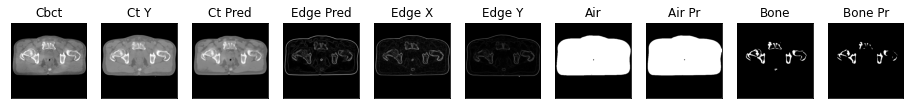

137it [01:06,  2.35it/s]

ssim score = 0.8306471109390259
psnr score = 22.6436767578125
snr score = 14.161081314086914
mae error = 0.03267594426870346
air dice score = 0.9982980937163255
bone dice score = 0.8159771754662485
contour dice score = 0.5466464757919312


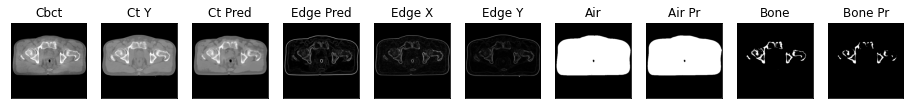

138it [01:06,  2.39it/s]

ssim score = 0.8285778164863586
psnr score = 22.724258422851562
snr score = 14.249448776245117
mae error = 0.03270919620990753
air dice score = 0.9984826170393192
bone dice score = 0.7860606060638475
contour dice score = 0.5161943435668945


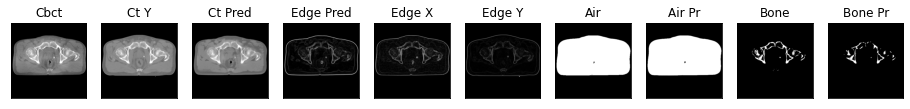

139it [01:07,  2.29it/s]

ssim score = 0.831820011138916
psnr score = 22.71867561340332
snr score = 14.185446739196777
mae error = 0.03187520056962967
air dice score = 0.9983132062515873
bone dice score = 0.8103881597345659
contour dice score = 0.5512690544128418


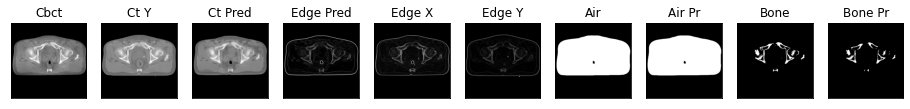

140it [01:08,  1.61it/s]

ssim score = 0.8351523876190186
psnr score = 22.95893096923828
snr score = 14.2700777053833
mae error = 0.02910533919930458
air dice score = 0.9982403989427432
bone dice score = 0.85429520645698
contour dice score = 0.5452696084976196


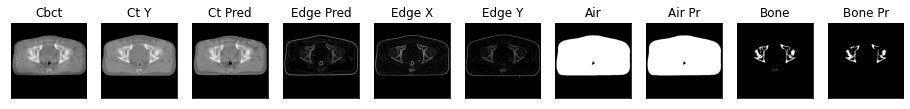

141it [01:08,  1.72it/s]

ssim score = 0.8388004899024963
psnr score = 23.12594223022461
snr score = 14.416284561157227
mae error = 0.02849302999675274
air dice score = 0.9982889048991367
bone dice score = 0.8593304308683481
contour dice score = 0.5730336904525757


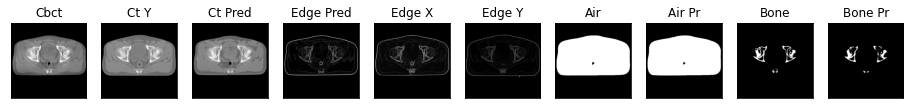

142it [01:09,  1.81it/s]

ssim score = 0.8377836346626282
psnr score = 23.120424270629883
snr score = 14.395137786865234
mae error = 0.028398070484399796
air dice score = 0.9980045330983969
bone dice score = 0.8777146188620067
contour dice score = 0.5579487085342407


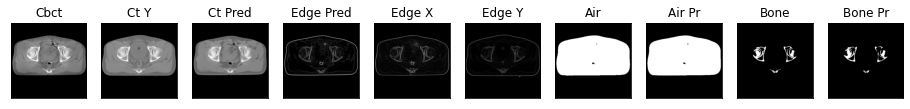

143it [01:09,  1.84it/s]

ssim score = 0.8348533511161804
psnr score = 22.586502075195312
snr score = 13.87057876586914
mae error = 0.030059000477194786
air dice score = 0.9977987730618251
bone dice score = 0.8792569659460525
contour dice score = 0.5723108649253845


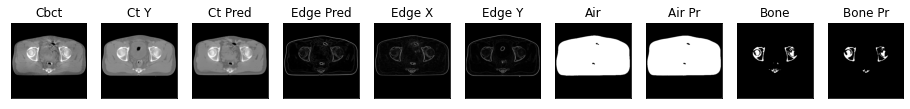

144it [01:10,  1.90it/s]

ssim score = 0.8287947177886963
psnr score = 22.65899658203125
snr score = 13.998855590820312
mae error = 0.030865371227264404
air dice score = 0.9982284805814231
bone dice score = 0.8993539124206841
contour dice score = 0.5023255944252014


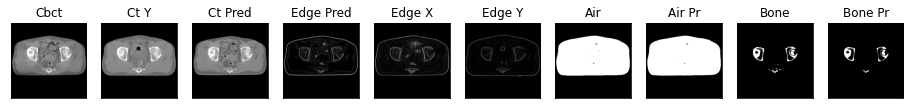

145it [01:10,  1.99it/s]

ssim score = 0.8266788125038147
psnr score = 22.246017456054688
snr score = 13.563945770263672
mae error = 0.03228292614221573
air dice score = 0.997877310042075
bone dice score = 0.9092516205081136
contour dice score = 0.47846394777297974


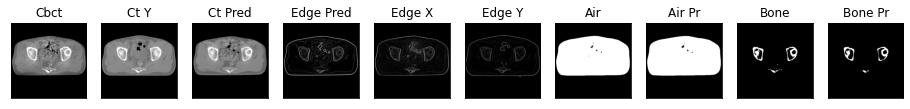

146it [01:11,  2.10it/s]

ssim score = 0.8280239105224609
psnr score = 21.854808807373047
snr score = 13.101963996887207
mae error = 0.0321812778711319
air dice score = 0.9977931013417044
bone dice score = 0.8903773893172623
contour dice score = 0.5294424295425415


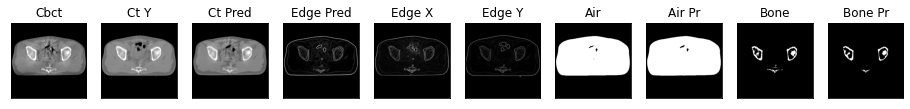

147it [01:11,  2.18it/s]

ssim score = 0.8322806358337402
psnr score = 22.11334991455078
snr score = 13.316612243652344
mae error = 0.03107304312288761
air dice score = 0.9979755074600656
bone dice score = 0.8873873873893384
contour dice score = 0.5489785075187683


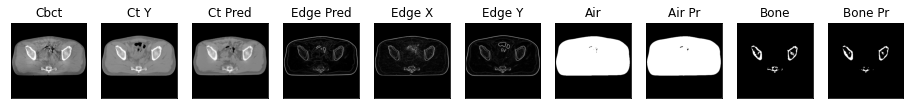

148it [01:12,  2.28it/s]

ssim score = 0.8354243636131287
psnr score = 22.360511779785156
snr score = 13.562675476074219
mae error = 0.030151234939694405
air dice score = 0.9977917158674433
bone dice score = 0.8950442182563817
contour dice score = 0.5664739608764648


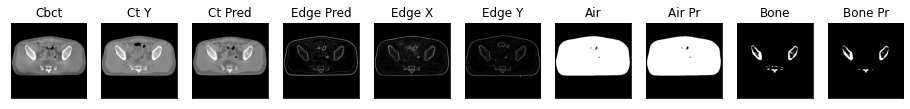

149it [01:12,  2.35it/s]

ssim score = 0.8287301659584045
psnr score = 22.31841278076172
snr score = 13.533934593200684
mae error = 0.030805762857198715
air dice score = 0.9972809132434182
bone dice score = 0.9021949644948
contour dice score = 0.557894766330719


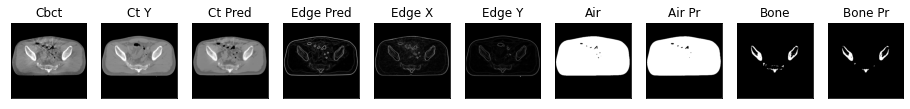

150it [01:13,  2.04it/s]

ssim score = 0.8257415294647217
psnr score = 22.123558044433594
snr score = 13.39428424835205
mae error = 0.03232744708657265
air dice score = 0.9974775611265881
bone dice score = 0.874057525832532
contour dice score = 0.5227032899856567


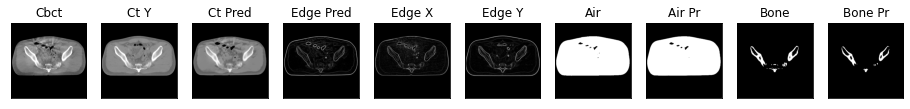

151it [01:13,  2.18it/s]

ssim score = 0.8281406164169312
psnr score = 21.77753448486328
snr score = 13.067630767822266
mae error = 0.03329482674598694
air dice score = 0.9973640550137245
bone dice score = 0.8500291205612983
contour dice score = 0.5798941850662231


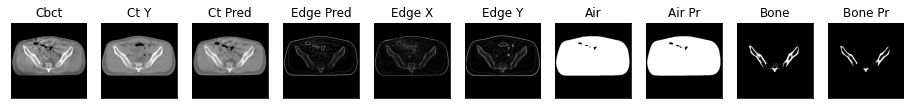

152it [01:13,  2.29it/s]

ssim score = 0.8320448994636536
psnr score = 22.03203582763672
snr score = 13.267393112182617
mae error = 0.031807128340005875
air dice score = 0.9972897630478571
bone dice score = 0.851763961400858
contour dice score = 0.48886531591415405


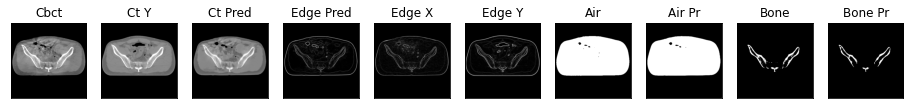

153it [01:14,  2.38it/s]

ssim score = 0.8356499671936035
psnr score = 22.31804084777832
snr score = 13.517046928405762
mae error = 0.030612941831350327
air dice score = 0.9976782342197337
bone dice score = 0.8297872340452968
contour dice score = 0.5077168941497803


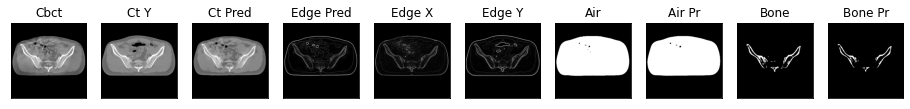

154it [01:14,  2.41it/s]

ssim score = 0.8392102122306824
psnr score = 22.50922966003418
snr score = 13.708304405212402
mae error = 0.029832754284143448
air dice score = 0.9976852747865284
bone dice score = 0.8116710875359318
contour dice score = 0.49866238236427307


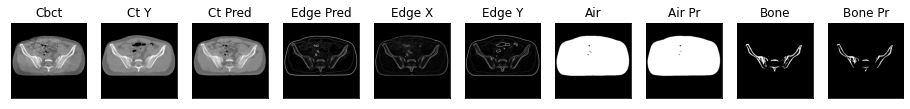

155it [01:15,  2.16it/s]

ssim score = 0.8377570509910583
psnr score = 22.659589767456055
snr score = 13.857244491577148
mae error = 0.029475266113877296
air dice score = 0.99799179660544
bone dice score = 0.815542652972822
contour dice score = 0.542227029800415


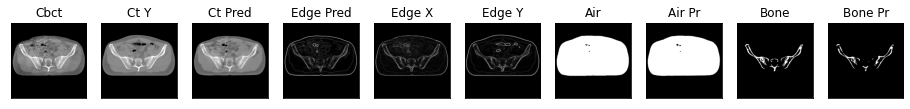

156it [01:16,  1.70it/s]

ssim score = 0.8315988779067993
psnr score = 22.13547134399414
snr score = 13.338166236877441
mae error = 0.030786223709583282
air dice score = 0.9975262158882304
bone dice score = 0.8006088280091231
contour dice score = 0.5521339774131775


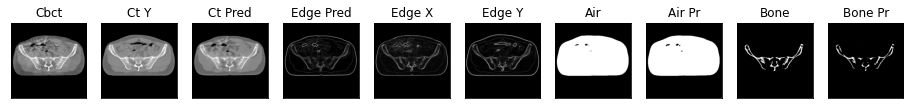

157it [01:16,  1.52it/s]

ssim score = 0.8271344900131226
psnr score = 21.631061553955078
snr score = 12.816481590270996
mae error = 0.03233431279659271
air dice score = 0.9963948041385488
bone dice score = 0.7837921435232943
contour dice score = 0.5193249583244324


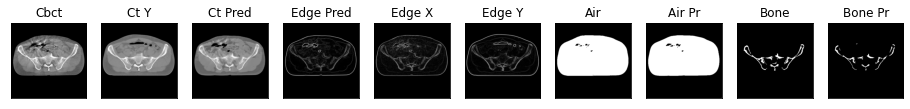

158it [01:17,  1.45it/s]

ssim score = 0.8237136006355286
psnr score = 21.344532012939453
snr score = 12.511329650878906
mae error = 0.03339014947414398
air dice score = 0.9967509025270783
bone dice score = 0.7820289855104053
contour dice score = 0.5679824352264404


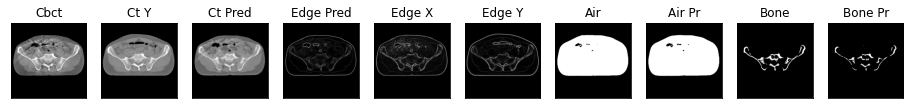

159it [01:18,  1.49it/s]

ssim score = 0.814399003982544
psnr score = 21.00701141357422
snr score = 12.127867698669434
mae error = 0.03442135453224182
air dice score = 0.996107171000791
bone dice score = 0.7660843630199391
contour dice score = 0.5449531078338623


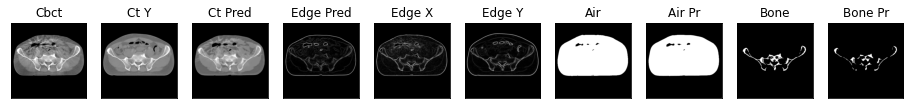

160it [01:19,  1.41it/s]

ssim score = 0.8097598552703857
psnr score = 21.0739688873291
snr score = 12.14102840423584
mae error = 0.03418811038136482
air dice score = 0.9958933050585969
bone dice score = 0.7876956880007183
contour dice score = 0.5191347599029541


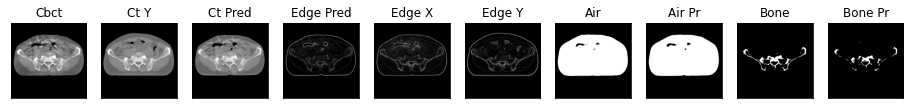

161it [01:19,  1.59it/s]

ssim score = 0.7999118566513062
psnr score = 20.637916564941406
snr score = 11.735443115234375
mae error = 0.036519113928079605
air dice score = 0.9957711324144324
bone dice score = 0.8069385593245904
contour dice score = 0.49331849813461304


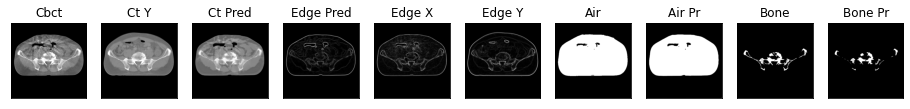

162it [01:20,  1.75it/s]

ssim score = 0.7967909574508667
psnr score = 20.473556518554688
snr score = 11.51585578918457
mae error = 0.03622160106897354
air dice score = 0.9957152641722848
bone dice score = 0.806367503776501
contour dice score = 0.48693719506263733


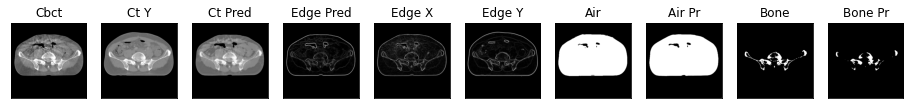

163it [01:20,  1.87it/s]

ssim score = 0.8054489493370056
psnr score = 21.207782745361328
snr score = 12.102551460266113
mae error = 0.03256214037537575
air dice score = 0.9964218260640912
bone dice score = 0.8359550561820793
contour dice score = 0.41834452748298645


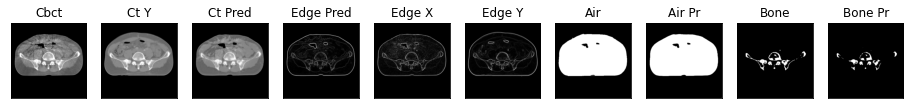

164it [01:20,  1.98it/s]

ssim score = 0.8565990924835205
psnr score = 25.42828369140625
snr score = 15.809197425842285
mae error = 0.020429905503988266
air dice score = 0.9960440468809996
bone dice score = 0.8953285036248981
contour dice score = 0.5079980492591858


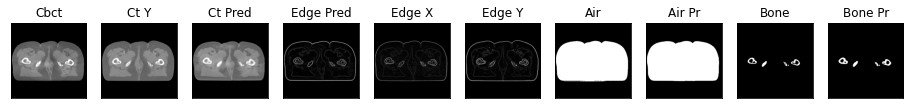

165it [01:21,  2.05it/s]

ssim score = 0.8573364615440369
psnr score = 25.675249099731445
snr score = 16.177173614501953
mae error = 0.020057788118720055
air dice score = 0.9962395818825575
bone dice score = 0.8953938872170599
contour dice score = 0.4938271641731262


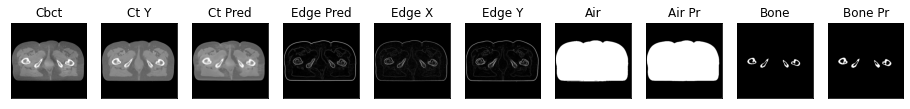

166it [01:21,  2.12it/s]

ssim score = 0.851757287979126
psnr score = 25.697978973388672
snr score = 16.282819747924805
mae error = 0.01999688148498535
air dice score = 0.9963798465987338
bone dice score = 0.8969601263344461
contour dice score = 0.4814453125


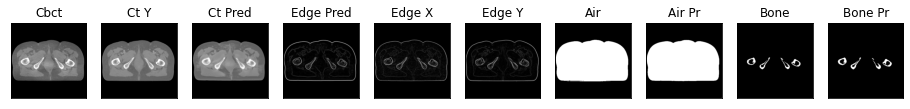

167it [01:22,  2.15it/s]

ssim score = 0.8473625779151917
psnr score = 25.64012336730957
snr score = 16.288408279418945
mae error = 0.020263804122805595
air dice score = 0.9964698121824125
bone dice score = 0.907509320079753
contour dice score = 0.483162522315979


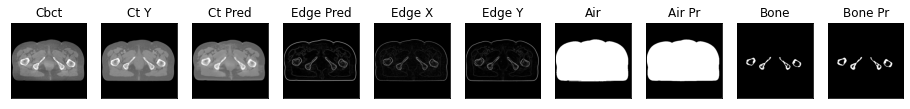

168it [01:22,  2.18it/s]

ssim score = 0.8463564515113831
psnr score = 25.45912742614746
snr score = 16.13587760925293
mae error = 0.020820867270231247
air dice score = 0.9963948993967443
bone dice score = 0.9269633957737247
contour dice score = 0.47885939478874207


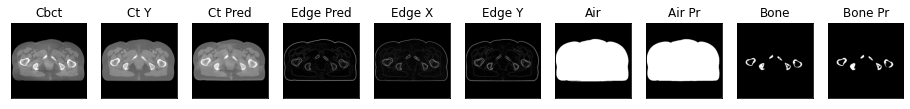

169it [01:23,  2.19it/s]

ssim score = 0.8483447432518005
psnr score = 25.35057830810547
snr score = 16.05027961730957
mae error = 0.020759543403983116
air dice score = 0.9964770213900301
bone dice score = 0.9179037739238436
contour dice score = 0.4810126721858978


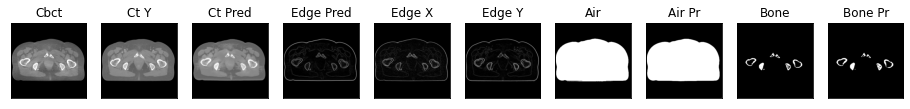

170it [01:23,  1.89it/s]

ssim score = 0.8462980389595032
psnr score = 25.260278701782227
snr score = 15.991310119628906
mae error = 0.020879335701465607
air dice score = 0.9963266215701383
bone dice score = 0.9150235560998949
contour dice score = 0.4678588807582855


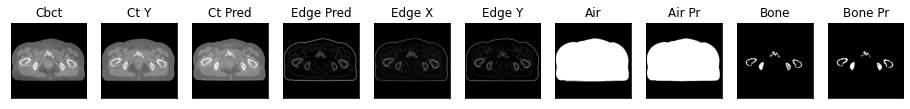

171it [01:24,  2.01it/s]

ssim score = 0.8456804156303406
psnr score = 25.11988639831543
snr score = 15.899280548095703
mae error = 0.02112637273967266
air dice score = 0.9961803561171768
bone dice score = 0.9053182214489046
contour dice score = 0.4624060094356537


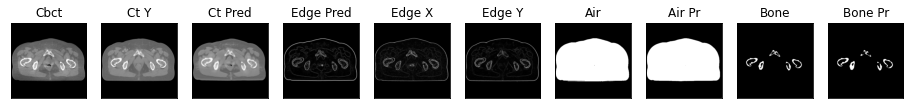

172it [01:24,  2.07it/s]

ssim score = 0.8473435044288635
psnr score = 24.74380874633789
snr score = 15.565947532653809
mae error = 0.021354274824261665
air dice score = 0.9961638482205742
bone dice score = 0.9113119143254466
contour dice score = 0.4618338942527771


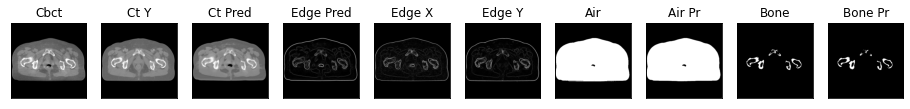

173it [01:25,  2.13it/s]

ssim score = 0.8480954170227051
psnr score = 24.711511611938477
snr score = 15.621349334716797
mae error = 0.021563313901424408
air dice score = 0.9960068945705286
bone dice score = 0.8775939849642467
contour dice score = 0.4661373198032379


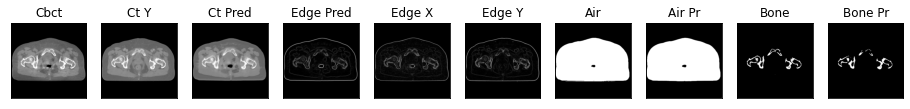

174it [01:25,  2.17it/s]

ssim score = 0.8467877507209778
psnr score = 25.37631607055664
snr score = 16.39942741394043
mae error = 0.021234119310975075
air dice score = 0.995581801023767
bone dice score = 0.8642652049091064
contour dice score = 0.4456721842288971


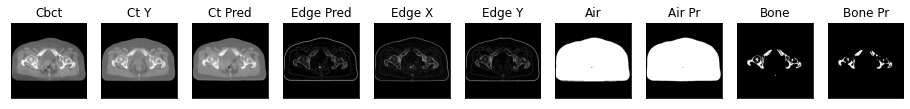

175it [01:26,  2.19it/s]

ssim score = 0.847822368144989
psnr score = 24.772233963012695
snr score = 15.66679573059082
mae error = 0.021300077438354492
air dice score = 0.9958690407153676
bone dice score = 0.8784596871260364
contour dice score = 0.467928022146225


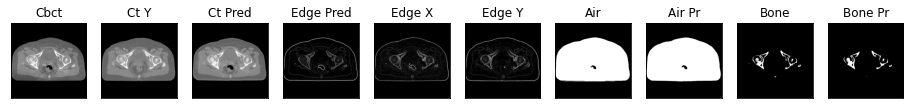

176it [01:26,  2.18it/s]

ssim score = 0.8479563593864441
psnr score = 24.822484970092773
snr score = 15.607625961303711
mae error = 0.021066630259156227
air dice score = 0.9957147251772446
bone dice score = 0.8630500758751318
contour dice score = 0.4918338656425476


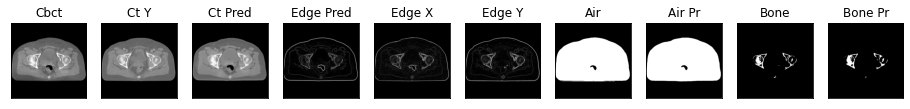

177it [01:26,  2.19it/s]

ssim score = 0.8497586250305176
psnr score = 24.81532859802246
snr score = 15.573339462280273
mae error = 0.02158551849424839
air dice score = 0.9958341655491227
bone dice score = 0.9027967257861051
contour dice score = 0.49450549483299255


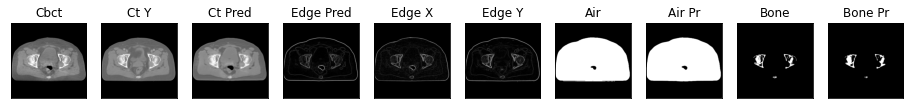

178it [01:27,  2.18it/s]

ssim score = 0.8547776937484741
psnr score = 25.41631507873535
snr score = 16.166322708129883
mae error = 0.021301649510860443
air dice score = 0.9959529065489359
bone dice score = 0.9066754141396314
contour dice score = 0.4496268630027771


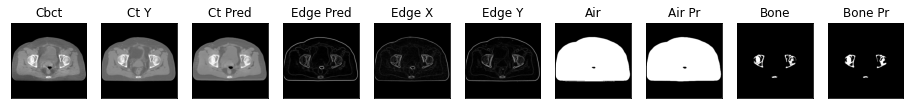

179it [01:27,  2.18it/s]

ssim score = 0.8566744923591614
psnr score = 26.167726516723633
snr score = 16.951963424682617
mae error = 0.01961347833275795
air dice score = 0.9964232614245263
bone dice score = 0.9125427948970971
contour dice score = 0.4598025381565094


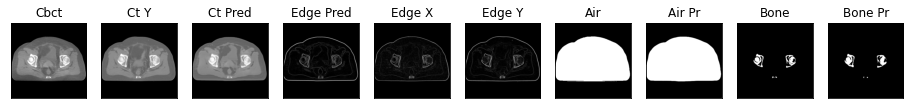

180it [01:28,  1.87it/s]

ssim score = 0.8530198335647583
psnr score = 25.76320457458496
snr score = 16.59893035888672
mae error = 0.02012796141207218
air dice score = 0.9969300169162355
bone dice score = 0.9333123127867994
contour dice score = 0.4667949974536896


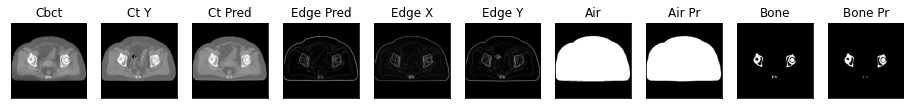

181it [01:29,  1.98it/s]

ssim score = 0.8399427533149719
psnr score = 24.872224807739258
snr score = 15.745511054992676
mae error = 0.02174890786409378
air dice score = 0.9970867620257379
bone dice score = 0.9248554913307573
contour dice score = 0.4806576371192932


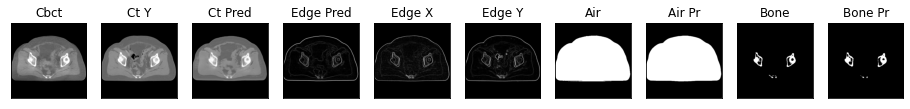

182it [01:29,  2.11it/s]

ssim score = 0.8248461484909058
psnr score = 23.23219108581543
snr score = 14.033041000366211
mae error = 0.02523195929825306
air dice score = 0.9967732432673161
bone dice score = 0.8831382214030984
contour dice score = 0.47432762384414673


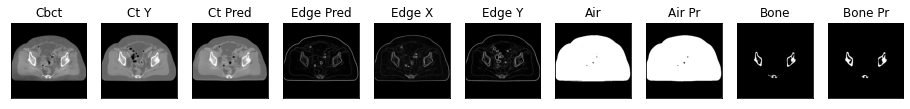

183it [01:29,  2.14it/s]

ssim score = 0.8151834607124329
psnr score = 22.845054626464844
snr score = 13.627909660339355
mae error = 0.02697504125535488
air dice score = 0.9969065561930222
bone dice score = 0.8960633201438021
contour dice score = 0.4511352479457855


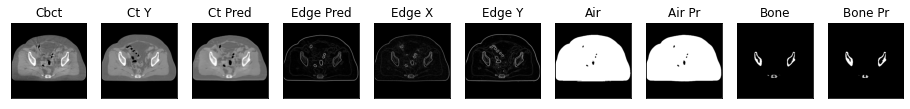

184it [01:30,  2.18it/s]

ssim score = 0.8130465149879456
psnr score = 23.45465087890625
snr score = 14.302420616149902
mae error = 0.026154974475502968
air dice score = 0.9969319154961889
bone dice score = 0.9056449969450653
contour dice score = 0.40276408195495605


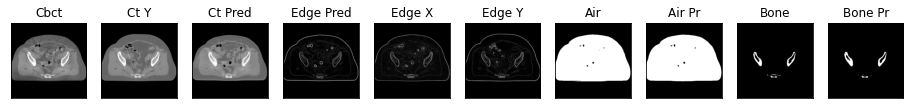

185it [01:30,  2.19it/s]

ssim score = 0.8115912675857544
psnr score = 23.624393463134766
snr score = 14.527259826660156
mae error = 0.025792423635721207
air dice score = 0.9964106437446969
bone dice score = 0.9177136789963243
contour dice score = 0.42608264088630676


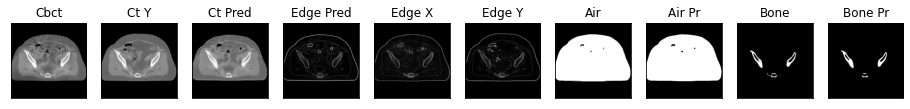

186it [01:31,  2.22it/s]

ssim score = 0.8084162473678589
psnr score = 22.961530685424805
snr score = 13.928825378417969
mae error = 0.027236048132181168
air dice score = 0.9963450970005984
bone dice score = 0.9270502945185463
contour dice score = 0.3821218013763428


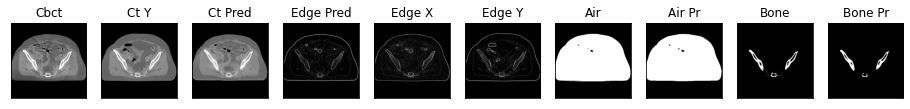

187it [01:31,  2.23it/s]

ssim score = 0.8064854741096497
psnr score = 22.809818267822266
snr score = 13.849969863891602
mae error = 0.027882400900125504
air dice score = 0.9963344456998736
bone dice score = 0.9048958919540673
contour dice score = 0.32709360122680664


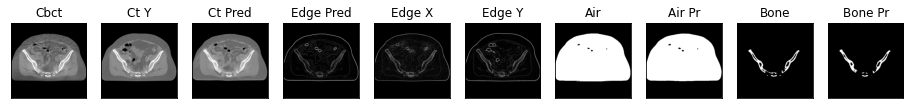

188it [01:32,  2.23it/s]

ssim score = 0.8013247847557068
psnr score = 22.714889526367188
snr score = 13.750754356384277
mae error = 0.028492804616689682
air dice score = 0.9963462527924162
bone dice score = 0.8957746478887919
contour dice score = 0.3552952706813812


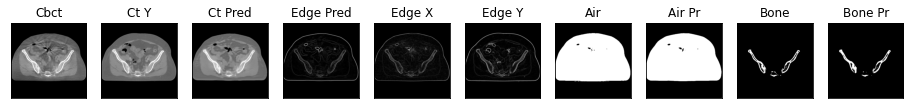

189it [01:32,  2.18it/s]

ssim score = 0.8019624352455139
psnr score = 22.873327255249023
snr score = 13.88701343536377
mae error = 0.027797142043709755
air dice score = 0.9965672547071219
bone dice score = 0.903093347934532
contour dice score = 0.3519146740436554


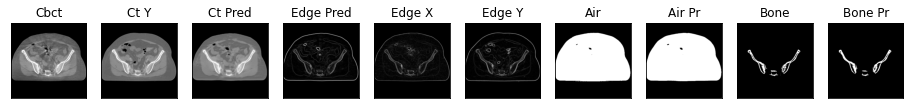

190it [01:33,  1.88it/s]

ssim score = 0.8078579306602478
psnr score = 23.514057159423828
snr score = 14.539377212524414
mae error = 0.026517262682318687
air dice score = 0.9966103862880554
bone dice score = 0.8964924838955406
contour dice score = 0.3604819178581238


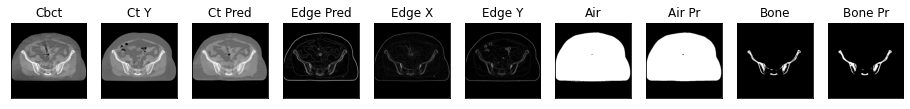

191it [01:33,  2.04it/s]


In [46]:
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=4)
test_epoch(model, testloader, device, True, os.path.join("eval-gan", wandb.run.name))

In [47]:
tf_discriminator = Discriminator(in_channel=DIS_IN_CHANNELS, n_classes=DIS_N_CLASSES, activation=DIS_ACT)
replace_relu_to_leakyReLU(tf_discriminator)
replace_bn_to_instanceNorm(tf_discriminator)
tf_discriminator.load_state_dict(checkpoint["tf_discriminator"])

<All keys matched successfully>

In [48]:
edge_discriminator = Discriminator(in_channel=E_IN_CHANNELS, n_classes=E_N_CLASSES, activation=E_ACT)
replace_relu_to_leakyReLU(edge_discriminator)
replace_bn_to_instanceNorm(edge_discriminator)
edge_discriminator.load_state_dict(checkpoint["edge_discriminator"])

<All keys matched successfully>

In [49]:
# score_ssim_test, score_psnr_test, score_snr_test, score_mae_test, \
#             score_air_test, score_bone_test, score_cont_test, score_tf_acc_test, score_edge_acc_test
eval_epoch(model, tf_discriminator, edge_discriminator, testloader, device)

191it [00:19,  9.64it/s]


(0.8335763627946065,
 23.3061956435598,
 14.310467700059501,
 0.02841728902299991,
 0.996848789770518,
 0.8615822573440921,
 0.4753542253796343,
 0.5,
 0.4973821989528796)

In [50]:
# import torchvision.models as models
# models.vgg16(pretrained=True)